In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# # Create a specific directory and EXTRACT LibreSevoc there
# !mkdir -p LibriSeVoc_extracted
# !unzip -o '/content/drive/My Drive/CYBR_4980_Project/Dataset/LibriSeVoc.zip' -d LibriSeVoc_extracted

In [3]:
# Import standard libraries
import time
import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

# Import pickle for object serialization
import pickle

# Import standard data science libraries
import random
import numpy as np
import pandas as pd

# Import PyTorch and related libraries
import torch

# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higherfrom torchmetrics import ConfusionMatrix

from torch.utils.data import DataLoader, Dataset, Subset, random_split, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from mlxtend.plotting import plot_confusion_matrix

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import imbalanced-learn for handling imbalanced datasets if we decide to use it
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Import scikit-learn for various utilities
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for enhanced visualizations

# Import scalars
from sklearn.preprocessing import RobustScaler, StandardScaler


# Import audio processing libraries
import scipy
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import scipy.io.wavfile as wavfile
import scipy.signal
import librosa
import librosa.display

# Import collections for Counter
from collections import Counter




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.9 MB/s eta 0:00:00
mlxtend version: 0.23.4
0.23.4


In [4]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler

class ClassesFilesDictionarySetUp(Dataset):
    """
    A class to set up and manage dataset properties such as device, directory, classes, class counts,
    data length, transform flag, class indices, and file dictionary.
    If the file we're working with is a .wav file, we use librosa to load it properly and create a 2d array (spectrogram).
    Other file types are loaded as raw byte data (works well for 1d data).

    """
    def __init__(self, directory: str = '', file_extension: str = '.wav', DL_type: str = 'RNN') -> None:
        """
        Initialize the dataset setup with directory and file extension.
        All other parameters use default values from private attributes.

        Parameters:
            directory (str): The directory path of the dataset. Defaults to an empty string.
            file_extension (str): The file extension to filter files. Defaults to '.wav'.
            DL_type (str): The type of deep learning model to use. Defaults to 'RNN'.
            Will eventually fully support '1DCNN' and '2DCNN' as well.

        Returns:
            None
        """

        super().__init__() # Initialize the parent Dataset class

        # Initialize private attributes with default values
        self.__device: torch.device = torch.device("cpu")  # Default to CPU
        self.__directory: str = 'None' # Default to 'None' indicating no directory set
        self.__classes: List[str] = [] # List of class names
        self.__classes_index: Dict[str, int] = {} # Mapping of class names to indices
        self.__class_counts: Dict[str, int] = {} # Mapping of class names to their respective counts

         # Mapping of class indices to lists of file paths
         # Example: {0: ['path/to/class0/file1.wav', 'path/to/class0/file2.wav'], 1: ['path/to/class1/file1.wav']}
        self.__file_dictionary = {}

        self.__data_length: int = 1048576 # Fixed length for data samples (in bytes) for non-.wav files

        self.__sample_rate: int = 44100 # The sample rate for audio files (basically a measure of quality in Hz)
        self.__duration: int = 8 # Duration of audio clips in seconds
        # self.__n_mels: int = 128 # Number of Mel bands to generate (used for 2DCNN spectrograms)
        self.__n_mfcc: int = 40 # Number of MFCCs to generate (needed if we're dealing with MFCC features)
        self.__n_fft: int = 2048 # Size of the FFT window
        self.__hop_length: int = 512 # Number of samples between successive frames

        self.__DL_type: str = 'RNN' # Type of deep learning model to use (RNN, 1DCNN, 2DCNN)

        # Add StandardScaler for feature normalization
        self.__scaler: Optional[StandardScaler | RobustScaler] = StandardScaler()  # Default to StandardScaler
        self.__use_scaler: bool = True  # Flag to enable/disable scaling


        # Choose device: prefer CUDA when available
        # Perform setup actions (these methods set the private attributes internally)
        self.setupDevice()

        # Prefer provided directory when calling set_directory
        if directory is not None and directory != '':
            self.set_directory(directory)
        else:
            self.set_directory()

        # Ensure classes and counts are initialized
        self.set_classes()
        self.set_class_counts()

        # Initialize class index mapping and create classes and counts
        self.create_classes_and_class_counts()

        # Set up file dictionary by scanning the dataset directory
        self.setup_file_dictionary(file_extension)

        # Set the deep learning model type (RNN, 1DCNN, 2DCNN)
        self.set_DL_type(DL_type)

        # Use setters to ensure our private attributes are set correctly
        self.set_data_length(self.__data_length)
        self.set_sample_rate(self.__sample_rate)
        self.set_duration(self.__duration)
        self.set_n_mfcc(self.__n_mfcc)
        self.set_n_fft(self.__n_fft)
        self.set_hop_length(self.__hop_length)


    def get_device(self) -> torch.device:
        """
        Get the device used for PyTorch computations.

        Parameters:
            None

        Returns:
            torch.device: The device (CPU or GPU). If not set, defaults to CPU.
        """

        # Ensure device is set and available
        if not self.__device or not torch.cuda.is_available():
            self.__device = torch.device("cpu")

        return self.__device

    def set_device(self, device: torch.device) -> None:
        """
        Set the device for PyTorch computations.

        Parameters:
            device (torch.device): The device to set (CPU or GPU). If None or CUDA not available, defaults to CPU.

        Returns:
            None
        """

        # Ensure device is valid and available
        if device == None or not torch.cuda.is_available():
            self.__device = torch.device("cpu")

        self.__device = device

    def get_directory(self) -> str:
        """
        Get the directory path of the dataset.

        Parameters:
            None

        Returns:
            str: The directory path. If empty, raises an error.
        """

        # Ensure directory is set
        if not self.__directory or not os.path.isdir(self.__directory):
            raise ValueError("Directory is not set or does not exist.")

        return self.__directory

    def set_directory(self, directory: str = '') -> None:
        """
        Set the directory path of the dataset.

        Parameters:
            directory (str): The directory path to set. If empty, raises an error.

        Returns:
            None
        """

        # Ensure directory is valid by checking if it exists and is a directory
        if not directory or not os.path.isdir(directory):
            raise ValueError("Provided directory is not valid or does not exist.")

        self.__directory = directory

    def get_classes(self) -> List[str]:
        """
        Get the list of classes in the dataset. If empty, raises an error.
        e.g.: ['class0', 'class1', 'class2']

        Parameters:
            None

        Returns:
            List[str]: The list of class names.
        """

        # Ensure classes at least has a default value
        if not self.__classes:
           raise ValueError("Classes list is empty.")

        return self.__classes

    def set_classes(self, classes: List[str] = []) -> None:
        """
        Set the list of classes in the dataset by scanning the directory structure.
        e.g.: ['class0', 'class1', 'class2']

        Parameters:
            classes (List[str], optional): The list of class names to set. If empty, raises an error.

        Returns:
            None
        """

        # Ensure classes is a list of strings
        if classes is not None:
            self.__classes = classes
        elif not self.__classes:
            raise ValueError("Classes list is empty.")

    def get_class_counts(self) -> Dict[str, int]:
        """
        Get the counts of samples per class in the dataset.
        eg.: {'class0': 100, 'class1': 150, 'class2': 200}

        Parameters:
            None

        Returns:
            Dict[str, int]: A dictionary with class names as keys and their respective counts as values.
            If empty, raises an error.
        """

        # Ensure class counts at least has a default value
        if not self.__class_counts:
            raise ValueError("Class counts dictionary is empty.")

        return self.__class_counts

    def set_class_counts(self, class_counts: Dict[str, int] = {}) -> None:
        """
        Set the counts of samples per class in the dataset by scanning the directory structure.
        eg.: {'class0': 100, 'class1': 150, 'class2': 200}

        Parameters:
            class_counts (Dict[str, int], optional): A dictionary with class names as keys and their respective counts as values.
            If empty, raises an error.

        Returns:
            None
        """

        # Ensure class counts is a dictionary with a tuple of (string, integer)
        if class_counts is not None:
            self.__class_counts = class_counts
        elif not self.__class_counts:
            raise ValueError("Class counts dictionary is empty.")

    def get_data_length(self) -> int:
        """
        Get the fixed length for data samples.
        e.g.: 1048576 (in bytes)

        Parameters:
            None
        Returns:
            int: The fixed length for data samples.
        """

        return self.__data_length

    def set_data_length(self, data_length: int) -> None:
        """
        Set the fixed length for data samples.
        e.g.: 1048576 (in bytes)

        Parameters:
            data_length (int): The fixed length to set for data samples.

        Returns:
            None
        """

        # If data_length is positive, set it; otherwise, raise an error
        if data_length > 0:
            self.__data_length = data_length
        else:
            raise ValueError("Data length must be a positive integer.")

    def get_classes_index(self) -> Dict[str, int]:
        """
        Get the mapping of class names to their respective indices.
        e.g.: {'class0': 0, 'class1': 1, 'class2': 2}

        Parameters:
            None

        Returns:
            Dict[str, int]: A dictionary mapping class names to their respective indices.
            If empty, raises an error.
        """

        # Ensure classes index at least is a dictionary with a tuple of (string, integer)
        if not self.__classes_index:
            raise ValueError("Classes index dictionary is empty.")

        return self.__classes_index

    def set_classes_index(self, classes_index: Dict[str, int] = {}) -> None:
        """
        Set the mapping of class names to their respective indices.
        e.g.: {'class0': 0, 'class1': 1, 'class2': 2}

        Parameters:
            classes_index (Dict[str, int], optional): A dictionary mapping class names to their respective indices.
            If empty, raises an error.

        Returns:
            None
        """

        # Ensure classes index is at least a dictionary with a tuple of (string, integer)
        if classes_index is not None:
            self.__classes_index = classes_index
        elif not self.__classes_index:
            raise ValueError("Classes index dictionary is empty.")


    def get_file_dictionary(self) -> Dict[int, List[str]]:
        """
        Get the dictionary of file paths along with their corresponding class indices.
        e.g.: {0: ['file1.wav', 'file2.wav'], 1: ['file3.wav', 'file4.wav']}

        Parameters:
            None

        Returns:
            Dict[int, List[str]]: A dictionary mapping class indices to lists of file paths.
            If empty, raises an error.
        """

        # Return the file dictionary mapping class_index -> list[str].
        # If empty, raise an error.
        if not self.__file_dictionary:
            raise ValueError("File dictionary is empty.")
        else:
            return self.__file_dictionary

    def set_file_dictionary(self, file_dictionary: Dict[int, List[str]]) -> None:
        """
        Set the dictionary of file paths along with their corresponding class indices.
        e.g.: {0: ['file1.wav', 'file2.wav'], 1: ['file3.wav', 'file4.wav']}

        Parameters:
            file_dictionary (Dict[int, List[str]]): A dictionary mapping class indices to lists of file paths.

        Returns:
            None
        """

        # Accept a dictionary mapping class_index -> list[str]
        if file_dictionary is not None and isinstance(file_dictionary, dict):
            self.__file_dictionary = file_dictionary
        else:
            raise ValueError("File dictionary cannot be None.")

    def get_sample_rate(self) -> int:
        """
        Get the sample rate for audio files.
        e.g.: 44100 Hz

        Parameters:
            None

        Returns:
            int: The sample rate in Hz.
        """
        return self.__sample_rate

    def set_sample_rate(self, sample_rate: int) -> None:
        """
        Set the sample rate for audio files.
        e.g.: 44100 Hz

        Parameters:
            sample_rate (int): The sample rate in Hz.

        Returns:
            None
        """

        # If sample_rate is positive and reasonable, set it.
        if sample_rate > 10000 and isinstance(sample_rate, int):
            self.__sample_rate = sample_rate

        # Otherwise, raise an error
        else:
            raise ValueError("Sample rate must be a positive integer and of a reasonable value above 10000 Hz.")

    def get_duration(self) -> int:
        """
        Get the duration of audio clips.
        e.g.: 8 seconds

        Parameters:
            None

        Returns:
            int: The duration in seconds.
        """
        return self.__duration

    def set_duration(self, duration: int) -> None:
        """
        Set the duration of audio clips.
        e.g.: 8 seconds

        Parameters:
            duration (int): The duration in seconds.

        Returns:
            None
        """
        if duration > 0 or isinstance(duration, int):
            self.__duration = duration
        else:
            raise ValueError("Duration must be a positive integer and not a float.")

    def get_n_mfcc(self) -> int:
        """
        Get the number of MFCCs to generate.
        e.g.: 40 MFCCs

        Parameters:
            None

        Returns:
            int: The number of MFCCs.
        """
        return self.__n_mfcc

    def set_n_mfcc(self, n_mfcc: int) -> None:
        """
        Set the number of MFCCs to generate.
        e.g.: 40 MFCCs

        Parameters:
            n_mfcc (int): The number of MFCCs.

        Returns:
            None
        """

        # Ensure n_mfcc is a positive integer between 1 and 40
        if 40 >= n_mfcc > 0 and isinstance(n_mfcc, int):
            self.__n_mfcc = n_mfcc
        else:
            raise ValueError("Number of MFCCs must be a positive integer between 1 and 40 and not a float.")

    # TODO: Implement 2DCNN get and set for n_mels

    def get_n_fft(self) -> int:
        """
        Get the size of the FFT window.
        The FFT (Fast Fourier Transform) window size determines the number of samples/points
        in the window.
        e.g.: 2048 samples/points

        Parameters:
            None

        Returns:
            int: The size of the FFT window.
        """
        return self.__n_fft

    def set_n_fft(self, n_fft: int) -> None:
        """
        Set the size of the FFT window.
        The FFT (Fast Fourier Transform) window size determines the number of samples/points
        in the window.
        e.g.: 2048 samples/points

        Parameters:
            n_fft (int): The size of the FFT window.

        Returns:
            None
        """

        # Ensure n_fft is a positive integer
        if n_fft > 0 and isinstance(n_fft, int):
            self.__n_fft = n_fft
        else:
            raise ValueError("Size of FFT window must be a positive integer and not a float.")

    def get_hop_length(self) -> int:
        """
        Get the number of samples between successive frames.
        The hop length determines how much the window shifts between successive frames.
        By window, we mean the segment of audio data being analyzed at a time.
        e.g.: 512 samples

        Parameters:
            None

        Returns:
            int: The hop length.
        """
        return self.__hop_length

    def set_hop_length(self, hop_length: int) -> None:
        """
        Set the number of samples between successive frames.
        The hop length determines how much the window shifts between successive frames.
        By window, we mean the segment of audio data being analyzed at a time.
        e.g.: 512 samples

        Parameters:
            hop_length (int): The hop length.

        Returns:
            None
        """

        # Ensure hop_length is a positive integer
        if hop_length > 0 and isinstance(hop_length, int):
            self.__hop_length = hop_length
        else:
            raise ValueError("Hop length must be a positive integer and not a float.")

    def get_DL_type(self) -> str:
        """
        Get the type of deep learning model to use.
        e.g.: 'RNN', '1DCNN', '2DCNN'

        Parameters:
            None

        Returns:
            str: The deep learning model type.
        """

        return self.__DL_type

    def set_DL_type(self, DL_type: str) -> None:
        """
        Set the type of deep learning model to use.
        e.g.: 'RNN', '1DCNN', '2DCNN'

        Parameters:
            DL_type (str): The deep learning model type.

        Returns:
            None
        """

        # Ensure DL_type is one of the supported types
        if DL_type in ['RNN', '1DCNN', '2DCNN']:
            self.__DL_type = DL_type
        else:
            raise ValueError("Deep learning model type must be one of: 'RNN', '1DCNN', '2DCNN'.")

    def get_scaler(self) -> StandardScaler | RobustScaler:
        """
        Get the Scaler used for feature normalization.
        The Scaler is used to normalize the features in the dataset.
        e.g.: StandardScaler() or RobustScaler()
        StandardScaler is used when the dataset does not contain or contains few outliers.
        RobustScaler can be used when the dataset contains outliers.

        Parameters:
            None

        Returns:
            Optional[StandardScaler | RobustScaler]: The fitted StandardScaler or RobustScaler.
        """

        if self.__scaler is None:
            raise ValueError("Scaler has not been set.")

        return self.__scaler

    def set_scaler(self, scaler: StandardScaler | RobustScaler) -> None:
        """
        Set the Scaler used for feature normalization.
        The Scaler is used to normalize the features in the dataset.
        e.g.: StandardScaler() or RobustScaler()
        StandardScaler is used when the dataset does not contain or contains few outliers.
        RobustScaler can be used when the dataset contains outliers.


        Parameters:
            scaler (StandardScaler | RobustScaler): The fitted StandardScaler or RobustScaler to set.

        Returns:
            None
        """

        # Ensure scalar is either StandardScaler or RobustScaler
        if not isinstance(scaler, (StandardScaler, RobustScaler)):
            raise ValueError("Scaler must be an instance of StandardScaler or RobustScaler.")

        self.__scaler = scaler

    def get_use_scaler(self) -> bool:
        """
        Get whether to use Scaler for feature normalization.
        e.g.: True or False

        Parameters:
            None

        Returns:
            bool: Whether to use scaling.
        """

        return self.__use_scaler

    def set_use_scaler(self, use_scaler: bool) -> None:
        """
        Set whether to use Scaler for feature normalization.
        e.g.: True or False

        Parameters:
            use_scaler (bool): Whether to use scaling.

        Returns:
            None
        """

        # Ensure use_scaler is a boolean
        if not isinstance(use_scaler, bool):
            raise ValueError("use_scaler must be a boolean value (True or False).")

        self.__use_scaler = use_scaler


    def setupDevice(self) -> None:
        """
        Setup device for PyTorch computations by checking for CUDA availability.
        If CUDA is available, it sets the device to GPU; otherwise, it defaults to CPU.

        Parameters:
            None

        Returns:
            None
        """

        print(" =============================== Device Setup =============================== \n")

        self.set_device(torch.device("cuda")) # Try to set to CUDA
        print(f"Using device: {self.get_device()}") # Print the device being used

        # Check if CUDA is available and print relevant information (get_device will automatically default to CPU if not)
        if self.get_device().type == "cuda":

            try:
                # Print basic GPU info
                print("GPU:", torch.cuda.get_device_name(0))
                print("CUDA available:", torch.cuda.is_available())
            except Exception:
                print("Error accessing CUDA device information.")

        # Otherwise, default to CPU
        else:
            print("CUDA not available, using CPU.")
        print ("\n ----------------------------- Setup Complete ------------------------------ \n")


    def create_classes_and_class_counts(self) -> None:
        """
        This function sets up the logic needed to not only find the classes in the dataset directory
        and find their counts, but also to create a mapping from class names to indices.

        Parameters:
            None

        Returns:
            None
        """

        print(" \n=============================== Creating Classes, Class Counts, and Class Indices =============================== \n")

        # Go through the dataset directory, finding the name of each file within the directory, and ensure it is a directory
        # If it is, add it to the classes list
        classes: List[str] = sorted([d for d in os.listdir(self.get_directory()) if os.path.isdir(os.path.join(self.get_directory(), d))])

        # Set the classes found and print them
        self.set_classes(classes)
        print (" Classes found: ", list(self.get_classes()))

        # Now, create the class counts and class indices
        class_counts: Dict[str, int] = {}
        classes_index: Dict[str, int] = {}

        # For each class found, count the number of files in its directory and assign an index
        for index, class_name in enumerate(self.get_classes()):

            # Get the directory path for the current class by joining the base directory with the class name
            class_dir: str = os.path.join(self.get_directory(), class_name)

            # The class count is simply the number of files in that directory,
            # which can be found by getting a length of the list of files in a directory
            class_counts[class_name] = len(os.listdir(class_dir))

            # The index is simply the enumeration order (0, 1, 2, ...)
            # Basically we're saying: key: class_name -> value: index
            classes_index[class_name] = index

        # Store the class counts and indices and print them
        self.set_class_counts(class_counts)
        self.set_classes_index(classes_index)
        print (" Class counts: ", self.get_class_counts())
        print (" Class indices: ", self.get_classes_index())

        print (" \n----------------------------- Creation of Classes, Class Counts, and Class Indices Complete ------------------------------ \n")


    def setup_file_dictionary(self, file_type) -> None:
        """
        This function sets up the file lists by scanning the dataset directory
        and pairing each file path with its corresponding class index.
        Basically, it creates a dictionary mapping (int) class index -> ([str]) list of file paths for that class.

        Parameters:
            file_type (str): The file extension to filter files (e.g., '.wav').

        Returns:
            None
        """

        print(" \n=============================== Setting up File Dictionary =============================== \n")

        # Placeholder to build the file dictionary
        file_dict: Dict[int, List[str]] = {}

        # Placeholder for class directory path
        class_dir: str = ''

        # Placeholder to store filenames temporarily
        files: List[str] = []

        # Placeholder to store full file paths
        full_paths: List[str] = []

        # Placeholder for class index
        class_index: int = 0

        # Build a mapping from class index -> list of full file paths for that class
        for class_name in self.get_classes():

            # Get the directory path for the current class by joining the base directory with the class name
            class_dir: str = os.path.join(self.get_directory(), class_name)

            # Get all files with the correct extension first
            all_files = [f for f in os.listdir(class_dir) if f.endswith(file_type)]

            if class_name != 'gt':
                # Randomly sample up to 475 files from this class
                max_samples = min(475, len(all_files))
                sampled_files = random.sample(all_files, max_samples)
            else:
                # Randomly sample up to 700 files from this class
                max_samples = min(700, len(all_files))
                sampled_files = random.sample(all_files, max_samples)

            # Sort the sampled files
            files: List[str] = sorted(sampled_files)

            # Get the full paths by joining the class directory with each filename (needed if we want to load the actual data later)
            full_paths: List[str] = [os.path.join(class_dir, f) for f in files]

            # Get the class index from the class name using the previously created mapping
            class_index_temp: int | None = self.get_classes_index().get(class_name)

            # Safety check in case class name not found in index mapping
            if class_index_temp is None:
                raise ValueError(f"Class index for class '{class_name}' not found.")
            else:
                class_index = class_index_temp

            # Store the list of full paths under the class index
            file_dict[class_index] = full_paths

            # Print files for this class immediately with only basenames for readability
            basenames: List[str] = [os.path.basename(p) for p in full_paths]
            print(f"\n Class {class_name}: Files: {basenames}\n\n")

        # Store the dictionary
        self.set_file_dictionary(file_dict)

        # Update class counts to reflect actual sampled files
        updated_class_counts: Dict[str, int] = {}

        for class_name in self.get_classes():
            class_index = self.get_classes_index()[class_name]
            updated_class_counts[class_name] = len(file_dict[class_index])
        self.set_class_counts(updated_class_counts)

        # Print total number of files found
        total_files: int = sum(len(v) for v in file_dict.values())
        print(f" Total files found: {total_files} ")
        print(f" Updated class counts: {self.get_class_counts()} ")
        print (" \n----------------------------- File Dictionary Setup Complete ------------------------------ \n")


    def setup_data(self, class_index: int, file_index_within_class: int) -> Tuple[torch.Tensor | np.ndarray, int]:
        """
        This function will get a specific file in a class based on the provided class index and file index within that class,
        process data from it, and return the data along with its class index.

        Parameters:
            class_index (int): The index of the class.
            file_index_within_class (int): The index of the file within the specified class.

        Returns:
            Tuple[torch.Tensor | bytes | np.ndarray, int]: A tuple containing the processed data and its corresponding class index.

            The exact format depends on DL_type:

            - RNN mode (DL_type='RNN' and file_type = '.wav'):
              Returns (torch.Tensor, int) where:
                - Tensor shape: (time_steps, n_mfcc)
                - time_steps = (sample_rate * duration) // hop_length + 1
                - Features are MFCC coefficients extracted via librosa
                - n_mfcc is the number of MFCCs, where MFCCs are Mel-Frequency Cepstral Coefficients
                - Mel-Frequency Cepstral Coefficients (MFCCs) are a compact representation of the spectral
                  envelope of audio signals. They capture high-frequency characteristics while being robust
                  to pitch variations, making them effective features for distinguishing audio patterns.
                - Audio is loaded with fixed duration and padded/truncated to exact length

            TODO:
            - 2DCNN mode (DL_type='2DCNN' and file_type = '.wav'):
              Returns (torch.Tensor, int) where:
                - Tensor shape: (1, n_mels, time_steps)
                - First dimension is channel (1 for grayscale spectrogram)
                - n_mels is the number of mel frequency bins
                - time_steps = (sample_rate * duration) // hop_length + 1
                - Data is mel-spectrogram in dB scale
                - Audio is loaded with fixed duration and padded/truncated to exact length

            - 1DCNN mode (DL_type='1DCNN' and file_type != '.wav'):
              Returns (np.ndarray, int) where:
                - Array contains raw byte data from non-.wav files
                - Length is data_length bytes, zero-padded if file is shorter
        """


        signal: np.ndarray # The audio signal
        sr: int | float # The sample rate

        # Retrieve the dictionary of files
        file_dict: Dict[int, List[str]] = self.get_file_dictionary()

        # Validate class index
        if class_index not in file_dict:
            raise IndexError(f"Class index {class_index} not found in file dictionary.")

        # Validate file index within the class
        class_files: List[str] = file_dict[class_index]
        if file_index_within_class < 0 or file_index_within_class >= len(class_files):
            raise IndexError(f"File index {file_index_within_class} out of range for class index {class_index}.")

        # Get the file path
        file_path: str = class_files[file_index_within_class]

        # If the file is a .wav file, use librosa to load it properly
        if os.path.splitext(file_path)[1] == '.wav' and self.get_DL_type() in ['RNN']:

            # Use librosa to load the audio file
            try:
                signal: np.ndarray
                sr: int | float

                signal, sr = librosa.load(file_path, sr=self.get_sample_rate(), duration=self.get_duration())

            # Catch errors during audio loading
            except Exception as e:

                print(f"\nWarning: Failed to load audio file: {file_path}")
                print(f"Error: {e}")
                print("Returning zeros as fallback.\n")

                # Return zeros with expected shape as fallback
                signal: np.ndarray = np.zeros(self.get_sample_rate() * self.get_duration())

                # Get the sample rate for consistency
                sr: int | float = self.get_sample_rate()

            # Ensure signal has fixed length
            target_length: int = self.get_sample_rate() * self.get_duration()

            # Pad the signal to the target length
            if len(signal) < target_length:
                signal: np.ndarray = np.pad(signal, (0, target_length - len(signal)), mode='constant')

            # Truncate the signal if it's longer than target length
            else:
                signal: np.ndarray = signal[:target_length]

            # Extract MFCC features (output shape: (n_mfcc/features, time_steps))
            mfccs: np.ndarray = librosa.feature.mfcc(
                y=signal,
                sr=sr,
                n_mfcc=self.get_n_mfcc(),
                n_fft=self.get_n_fft(),
                hop_length=self.get_hop_length())

            # Transpose to (time_steps, features) for RNN (RNNs expect time dimension first)
            mfccs = mfccs.T

            # Convert to tensor
            data: torch.Tensor | bytes | np.ndarray = torch.tensor(mfccs, dtype=torch.float32)

            # Apply scaling if scaler is fitted and enabled
            if self.get_use_scaler() is True and self.get_scaler() is not None:
                # Data is already in (time_steps, n_mfcc) format for RNN
                data_np = data.numpy()
                scaler = self.get_scaler()

                if scaler is not None:  # Additional safety check for type checker
                    data_scaled = scaler.transform(data_np)
                    data = torch.tensor(data_scaled, dtype=torch.float32)

        # TODO: If the file is a .wav file and we're using 2DCNN, process accordingly
        elif os.path.splitext(file_path)[1] == '.wav' and self.get_DL_type() in ['2DCNN']:
            data = torch.tensor([])  # Placeholder for 2DCNN processing

        # If the file is not a .wav file and we're using 1DCNN, read raw bytes
        elif os.path.splitext(file_path)[1] != '.wav' and self.get_DL_type() in ['1DCNN']:

            # Load the data from the file
            with open(file_path, 'rb') as f:
                # Read the specified number of bytes
                data = f.read(self.get_data_length())
                data = np.pad(data, (0, self.get_data_length() - len(data)), 'constant')  # Pad with zeros if needed
        else:
            raise ValueError(f"Unsupported file type or DL_type for file: {file_path}")


        return data, class_index


    def __getitem__(self, index: int) -> Tuple[Any, int]:
        """
        Uses setup_data function to retrieve a sample based on a flat index.
        Cumulative count works as a running tally! If we have 3 classes with 5, 10, and 15 samples respectively,
        and we look for index 12, we see that:
        - Class 0 (5 samples): cumulative count is 5, index 12 is greater than 5, move to next class
        - Class 1 (10 samples): cumulative count is 15, index 12 is less than 15, so it belongs to class 1
        - File index within class 1 is 12 - 5 = 7
        - Call setup_data with class_index=1 and file_index_within_class=7

        We know we'll get a valid flat index because PyTorch's DataLoader, train_test_split (stratified splitting),
        and our fit_scaler_on_training_data all use __len__(self) to determine valid index ranges (0 to len(self)-1),
        and len(self) returns the sum of all class counts, ensuring indices are within bounds.
        Therefore, we'll NEVER get the indices based on one class only - we always consider the entire dataset!

        For example, train_test_split gives us stratified indices like [0, 2048, 7, 591, 20, ...] which span across classes
        while maintaining proportional class distribution in train/validation/test splits.

        Parameters:
            index (int): The flat index of the sample.

        Returns:
            Tuple[Any, int]: A tuple containing the data and its corresponding class index.

        """

        # Placeholder for cumulative count of samples
        cumulative_count = 0

        # Iterate through classes to find the correct class for the given index
        for class_name in self.get_classes():

            # Get the count of samples in this class
            count = self.get_class_counts()[class_name]

            # Check if the index falls within this class's range (cumulative_count maintains the running total of samples)
            if index < cumulative_count + count:

                # Found the correct class
                class_index = self.get_classes_index()[class_name]
                file_index_within_class = index - cumulative_count # Calculate the file index within the class by subtracting cumulative count

                return self.setup_data(class_index, file_index_within_class) # Retrieve the item using setup_data

            # Update cumulative count for the next iteration
            cumulative_count += count

        # If we reach here, index is out of bounds
        raise IndexError(f"Index {index} out of range for dataset of size {cumulative_count}")

    def __len__(self) -> int:
        """
        Get the total number of samples in the dataset.
        If we have 3 classes with counts 100, 150, and 200, the total length is 450.
        (Note: If we choose a subsample of files per class during setup, like we did in setup_file_dictionary(), this should reflect that total subsample count.)

        Parameters:
            None

        Returns:
            int: The total number of samples across all classes.
        """

        total_samples: int = 0

        # Sum the counts of all classes to get the total number of samples
        for count in self.get_class_counts().values():
            total_samples += count

        return total_samples

    def fit_scaler_on_training_data(self, train_indices) -> None:
        """
        Fit the StandardScaler on training data features using optimized sampling.
        Uses time-step reduction for fast fitting.

        Parameters:
            train_indices: Indices of training samples to fit scaler on.

        Returns:
            None
        """

        # If scaling is not enabled, skip fitting
        if not self.get_use_scaler():
            return


        print( "\n=============================== Fitting StandardScaler on Training Data ===============================\n")

        # Limit to a maximum of 100 samples for fitting
        max_samples = min(100, len(train_indices))

        # Calculate step size for sampling
        sample_step = max(1, len(train_indices) // max_samples)

        # Sample indices with step size (max samples serves as an upper limit)
        sample_indices = train_indices[::sample_step][:max_samples]

        print(f"Using {len(sample_indices)} samples (out of {len(train_indices)}) for scaler fitting")

        training_features = []

        # Disable scaling temporarily during feature extraction
        # (we want raw features for fitting and if we don't disable, the scaler will try to scale data that hasn't been fitted yet...)
        self.set_use_scaler(False)

        # For each sampled index, extract features and subsample time steps
        for idx in sample_indices:

            try:
                # Get raw data (scaling disabled)
                # For RNN: data comes as (time_steps, features) - already in StandardScaler format
                data, _ = self.__getitem__(idx)

                # Convert to numpy array if it's a tensor (if we're dealing with RNN or 2DCNN, it should be)
                if isinstance(data, torch.Tensor):
                    data = data.numpy()

                # Handle different data shapes
                if self.get_DL_type() == 'RNN':
                    # data shape: (time_steps, features)
                    # Subsample every 7th time step to reduce data volume
                    training_features.append(data[::7])

                elif self.get_DL_type() == '2DCNN':
                    continue  # 2DCNN - spectrograms, skip scaling for now

                else:  # 1DCNN - raw bytes, no scaling needed
                    continue

            # Catch any exceptions during feature extraction
            except Exception as e:
                print(f"Warning: Could not process sample {idx} for scaler fitting: {e}")
                continue

        # Re-enable scaling after feature extraction
        self.set_use_scaler(True)

        # Fit StandardScaler if we have valid features
        if training_features:

            # Concatenate all features into a single array
            # np.concatenate stacks arrays along the first axis (rows)
            all_features: np.ndarray = np.concatenate(training_features, axis=0)

            print(f"Fitting scaler on {all_features.shape[0]} feature vectors (shape: {all_features.shape})")

            # Create a fresh Scaler instance and fit on all collected features at once
            if isinstance(self.get_scaler(), RobustScaler):
                scaler: StandardScaler | RobustScaler = RobustScaler() # Use RobustScaler if previously set

            elif isinstance(self.get_scaler(), StandardScaler):
                scaler: StandardScaler | RobustScaler = StandardScaler() # Use StandardScaler if previously set

            else:
                raise ValueError("Scaler must be set to either StandardScaler or RobustScaler before fitting.")

            scaler.fit(all_features)  # Fit on all collected feature vectors
            self.set_scaler(scaler)  # Store the newly fitted scaler

            print(f"StandardScaler fitted on {len(training_features)} training samples")

        # Error out if no valid features found
        else:
            print("Warning: No valid training features found for scaler fitting (disregard warning if using 1DCNN with raw byte data).")
            self.set_use_scaler(False)

        print ( "\n----------------------------- StandardScaler Fitting Complete ------------------------------\n")



In [5]:
class BatchLossAndOptimization(ClassesFilesDictionarySetUp, nn.Module):
    """
    A class to manage batch size, learning rate, and data splitting for training, validation, and testing sets,
    as well as set up Loss and Optimization for a DeepFake Detector.
    Inherits from ClassesFilesDictionarySetUp and nn.Module.
    """

    def __init__(self, directory: str = '', optim: str = 'Adam', loss: str = 'CrossEntropyLoss', file_extension: str = '.wav', DL_type: str = 'RNN') -> None:
        """
        Desc:
            Initialize the BatchLossAndOptimization class, including the class variables.
            Also, sets up the loss function and optimizer.

        Parameters:
            directory (str): The root directory containing the dataset files.
            optim (str): The name of the optimizer to use for training.
            loss (str): The name of the loss function to use for training.
            file_extension (str): The file extension of the dataset files.
            DL_type (str): The type of deep learning model ('RNN', '1DCNN', '2DCNN').

        Returns:
            None
        """

        # Initialize parent classes, including nn.Module, also send up directory, file_extension, and DL_type to ClassesFilesDictionarySetUp
        super(BatchLossAndOptimization, self).__init__(directory, file_extension, DL_type)

        # Initialize batch size, and learning rate
        self.__batch_size: int = 32
        self.__learning_rate: float = 0.001

        # Initialize data split proportions
        self.__train_size: float = 0.7 # 70% for training (what the model learns from)
        self.__valid_size: float = 0.15 # 15% for validation (tuning hyperparameters and early stopping)
        self.__test_size: float = 0.15 # 15% for testing (final unbiased evaluation)

        # Initialize DataLoaders
        self.__training_loader: Optional[DataLoader] = None # DataLoader for training set (the model learns from this data)
        self.__validation_loader: Optional[DataLoader] = None # DataLoader for validation set (used for hyperparameter tuning and early stopping)
        self.__testing_loader: Optional[DataLoader] = None # DataLoader for testing set (final unbiased evaluation of the model)

        # Initialize class weights for loss function
        self.__class_weights: Optional[torch.Tensor] = None

        # Set up optimizer and loss function
        self.__optim: type[torch.optim.Optimizer] = self.set_optim(optim)
        self.__loss_name: str = 'None'
        self.__loss: nn.Module = self.set_loss(loss)

    def get_batch_size(self) -> int:
        """
        Get the batch size, or the number of samples/files per batch
        e.g. if batch size is 32, each batch will contain 32 samples/files.

        Parameters:
            None

        Returns:
            int: The batch size.
        """

        return self.__batch_size

    def set_batch_size(self, batch_size: int) -> None:
        """
        Set the batch size, or the number of samples/files per batch.
        e.g. if batch size is 32, each batch will contain 32 samples/files

        Parameters:
            batch_size (int): The batch size to set.
        Returns:
            None
        """

        if batch_size <= 0:
            self.__batch_size = 1  # Ensure batch size is positive
        else:
            self.__batch_size = batch_size

    def get_learning_rate(self) -> float:
        """
        Get the learning rate, or the step size at each iteration while moving toward a minimum of a loss function.
        e.g. a learning rate of 0.001 means the model weights are updated by 0.1% of the value of the gradient at each step.

        Parameters:
            None

        Returns:
            float: The learning rate.
        """

        return self.__learning_rate

    def set_learning_rate(self, learning_rate: float) -> None:
        """
        Set the learning rate, or the step size at each iteration while moving toward a minimum of a loss function.
        e.g. a learning rate of 0.001 means the model weights are updated by 0.1% of the value of the gradient at each step.

        Parameters:
            learning_rate (float): The learning rate to set.

        Returns:
            None
        """

        if learning_rate <= 0.0:
            self.__learning_rate = 0.001  # Ensure learning rate is positive
        else:
            self.__learning_rate = learning_rate

    def get_train_size(self) -> float:
        """
        Get the training set size proportion, or the proportion of the dataset used for training.
        e.g. a train size of 0.7 means 70% of the dataset is used for training.

        Parameters:
            None

        Returns:
            float: The training set size proportion.
        """

        return self.__train_size

    def set_train_size(self, train_size: float) -> None:
        """
        Set the training set size proportion, or the proportion of the dataset used for training.
        e.g. a train size of 0.7 means 70% of the dataset is used for training.

        Parameters:
            train_size (float): The training set size proportion to set.

        Returns:
            None
        """

        # Ensure training is a "reasonable" proportion
        if 0.0 < train_size < 1.0:
            self.__train_size = train_size
        else:
            self.__train_size = 0.7  # Default to 70% if invalid

    def get_validation_size(self) -> float:
        """
        Get the validation set size proportion, or the proportion of the dataset used for validation.
        e.g. a validation size of 0.15 means 15% of the dataset is used for validation.

        Parameters:
            None

        Returns:
            float: The validation set size proportion.
        """

        return self.__valid_size

    def set_validation_size(self, validation_size: float) -> None:
        """
        Set the validation set size proportion, or the proportion of the dataset used for validation.
        e.g. a validation size of 0.15 means 15% of the dataset is used for validation.

        Parameters:
            validation_size (float): The validation set size proportion to set.

        Returns:
            None
        """

        # Ensure validation is a "reasonable" proportion
        if 0.0 < validation_size < 1.0:
            self.__valid_size = validation_size
        else:
            self.__valid_size = 0.15  # Default to 15% if invalid

    def get_test_size(self) -> float:
        """
        Get the testing set size proportion, or the proportion of the dataset used for testing.
        e.g. a test size of 0.15 means 15% of the dataset is used for testing.

        Parameters:
            None

        Returns:
            float: The testing set size proportion.
        """

        return self.__test_size

    def set_test_size(self, test_size: float) -> None:
        """
        Set the testing set size proportion, or the proportion of the dataset used for testing.
        e.g. a test size of 0.15 means 15% of the dataset is used for testing.

        Parameters:
            test_size (float): The testing set size proportion to set.

        Returns:
            None
        """

        # Ensure testing is a "reasonable" proportion
        if 0.0 < test_size < 1.0:
            self.__test_size = test_size
        else:
            self.__test_size = 0.15  # Default to 15% if invalid


    def get_training_loader(self) -> DataLoader:
        """
        Get the training data loader, which provides batches of training data during model training.
        The information in the DataLoader looks like: (batch_size, channels, time_steps, features) for RNN

        Parameters:
            None

        Returns:
            DataLoader: The training data loader.
        """

        # Check if the training loader is valid
        if self.__training_loader is None or not isinstance(self.__training_loader, DataLoader):
            raise ValueError("Training loader has not been set.")

        return self.__training_loader

    def set_training_loader(self, training_loader: DataLoader) -> None:
        """
        Set the training data loader, which provides batches of training data during model training.
        The information in the DataLoader looks like: (batch_size, time_steps, features) for RNN

        Parameters:
            training_loader (DataLoader): The training data loader to set.
            If None or not a DataLoader, raises an error.

        Returns:
            None
        """

        # Make sure we have a valid DataLoader
        if training_loader is None or not isinstance(training_loader, DataLoader):
            raise ValueError("Training loader cannot be None.")
        else:
            self.__training_loader = training_loader

    def get_validation_loader(self) -> DataLoader:
        """
        Get the validation data loader, which provides batches of validation data during model training.
        The information in the DataLoader looks like: (batch_size, time_steps, features) for RNN

        Parameters:
            None

        Returns:
            DataLoader: The validation data loader.
        """

        # Check if the validation loader is valid
        if self.__validation_loader is None or not isinstance(self.__validation_loader, DataLoader):
            raise ValueError("Validation loader has not been set.")

        return self.__validation_loader

    def set_validation_loader(self, validation_loader: DataLoader) -> None:
        """
        Set the validation data loader, which provides batches of validation data during model training.
        The information in the DataLoader looks like: (batch_size, time_steps, features) for RNN

        Parameters:
            validation_loader (DataLoader): The validation data loader to set.
            If None or not a DataLoader, raises an error.

        Returns:
            None
        """

        # Make sure we have a valid DataLoader
        if validation_loader is None or not isinstance(validation_loader, DataLoader):
            raise ValueError("Validation loader cannot be None.")
        else:
            self.__validation_loader = validation_loader

    def get_testing_loader(self) -> DataLoader:
        """
        Get the testing data loader, which provides batches of testing data during model evaluation.
        The information in the DataLoader looks like: (batch_size, time_steps, features) for RNN

        Parameters:
            None

        Returns:
            DataLoader: The testing data loader.
        """

        # Check if the testing loader is valid
        if self.__testing_loader is None or not isinstance(self.__testing_loader, DataLoader):
            raise ValueError("Testing loader has not been set.")

        return self.__testing_loader

    def set_testing_loader(self, testing_loader: DataLoader) -> None:
        """
        Set the testing data loader, which provides batches of testing data during model evaluation.
        The information in the DataLoader looks like: (batch_size, time_steps, features) for RNN

        Parameters:
            testing_loader (DataLoader): The testing data loader to set.
            If None or not a DataLoader, raises an error.

        Returns:
            None
        """

        # Make sure we have a valid DataLoader
        if testing_loader is None or not isinstance(testing_loader, DataLoader):
            raise ValueError("Testing loader cannot be None.")
        else:
            self.__testing_loader = testing_loader

    def get_optim(self) -> type[torch.optim.Optimizer]:
        """
        Get the optimizer for training.
        The optimizer updates the model weights based on the computed gradients during backpropagation.
        Backpropagation is the process of calculating how much each weight in the network contributed to the overall error,
        allowing efficient computation of gradients for deep networks.
        e.g. Adam optimizer adapts the learning rate for each parameter.

        Parameters:
            None

        Returns:
            type: The optimizer class.
        """

        return self.__optim

    def set_optim(self, optimizer_name: str) -> type[torch.optim.Optimizer]:
        """
        Lets the user decide what optimizer they wish to use for training.
        The optimizer updates the model weights based on the computed gradients during backpropagation.
        Backpropagation is the process of calculating how much each weight in the network contributed to the overall error,
        allowing efficient computation of gradients for deep networks.
        e.g. Adam optimizer adapts the learning rate for each parameter.

        Parameters:
            optimizer_name (str): The name of the optimizer. Includes 'SGD, 'Adam, 'NAdam', 'RAdam', 'AdamW', 'Adagrad', 'Adamax, 'Rprop', 'Rmsprop', and 'ASGD'.
            (Adam likely is the best choice for deep fake detection due to its adaptive learning rate capabilities.)

        Returns:
            type[torch.optim.Optimizer]: The chosen optimizer class.
        """

        # Define available optimizers
        optimizers: dict[str, type] = {
            'SGD': optim.SGD,
            'Adam': optim.Adam,
            'NAdam': optim.NAdam,
            'RAdam': optim.RAdam,
            'AdamW': optim.AdamW,
            'Adagrad': optim.Adagrad,
            'Adamax': optim.Adamax,
            'Rprop': optim.Rprop,
            'RMSprop': optim.RMSprop,
            'ASGD': optim.ASGD,
        }

        # If we do not have a valid optimizer, raise an error
        if optimizer_name not in optimizers:
            raise ValueError(f"Optimizer '{optimizer_name}' is not supported. Choose from: {list(optimizers.keys())}")
        else:
            return optimizers[optimizer_name]

    def get_class_weights(self) -> torch.Tensor:
        """
        Get the class weights tensor for loss function.
        Class weights are used to balance the importance of different classes in the loss function.
        It is a tensor where each element corresponds to the weight for a specific class.
        e.g. torch.tensor([1.0, 2.0, 0.5]) means class 0 has weight 1.0, class 1 has weight 2.0, and class 2 has weight 0.5.

        Parameters:
            None

        Returns:
            Optional[torch.Tensor]: The class weights tensor.
        """

        # Ensure class weights are valid
        if self.__class_weights is None or not isinstance(self.__class_weights, torch.Tensor):
            raise ValueError("Class weights have not been set.")

        return self.__class_weights

    def set_class_weights(self, class_weights: torch.Tensor) -> None:
        """
        Set the class weights tensor for loss function.
        Class weights are used to balance the importance of different classes in the loss function.
        It is a tensor where each element corresponds to the weight for a specific class.
        e.g. torch.tensor([1.0, 2.0, 0.5]) means class 0 has weight 1.0, class 1 has weight 2.0, and class 2 has weight 0.5.

        Parameters:
            class_weights (Optional[torch.Tensor]): The class weights tensor to set.

        Returns:
            None
        """

        # Ensure class weights are valid
        if class_weights is None and not isinstance(class_weights, torch.Tensor):
            raise ValueError("Class weights have not been set.")

        self.__class_weights = class_weights

    def get_loss_name(self) -> str:
        """
        Get the name of the loss function.
        e.g. 'CrossEntropyLoss' is commonly used for multi-class classification tasks.

        Parameters:
            None

        Returns:
            str: The name of the loss function.
        """
        return self.__loss_name

    def get_loss(self) -> nn.Module:
        """
        Get the loss function for training.
        The loss function measures how well the model's predictions match the true labels.
        The higher the loss, the worse the model is performing.
        For example, 2.0 is usually worse, while 0.3 is usually good
        e.g. CrossEntropyLoss is commonly used for multi-class classification tasks.

        Parameters:
            None

        Returns:
            nn.Module: The loss function instance.
        """
        return self.__loss

    def set_loss(self, loss_name: str, class_weights: Optional[torch.Tensor] = None) -> nn.Module:
        """
        Lets the user decide what loss function they wish to use for training.
        The loss function measures how well the model's predictions match the true labels.
        The higher the loss, the worse the model is performing.
        For example, 2.0 is usually worse, while 0.3 is usually
        e.g. CrossEntropyLoss is commonly used for multi-class classification tasks.

        Parameters:
            loss_name (str): The name of the loss function. Includes 'L1Loss', 'MSELoss', 'CrossEntropyLoss', 'NLLLoss', 'BCELoss', 'BCEWithLogitsLoss', 'HingeEmbeddingLoss', and 'SmoothL1Loss'.
            class_weights (Optional[torch.Tensor]): Class weights for CrossEntropyLoss. Ignored for other loss functions.

        Returns:
            nn.Module: The chosen loss function.
        """

        # Define available loss functions
        losses: dict[str, nn.Module] = {
            'L1Loss': nn.L1Loss(),
            'MSELoss': nn.MSELoss(),
            'CrossEntropyLoss': nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss(),
            'NLLLoss': nn.NLLLoss(),
            'BCELoss': nn.BCELoss(),
            'BCEWithLogitsLoss': nn.BCEWithLogitsLoss(),
            'HingeEmbeddingLoss': nn.HingeEmbeddingLoss(),
            'SmoothL1Loss': nn.SmoothL1Loss(),
        }

        if loss_name not in losses:
            raise ValueError(f"Loss function '{loss_name}' is not supported. Choose from: {list(losses.keys())}")

        # Store the loss name and return the loss function
        self.__loss_name = loss_name
        self.__loss = losses[loss_name]
        return self.__loss


    def split_data(self, train_size: float = 0.7, validation_size: float = 0.15, test_size: float = 0.15) -> None:
        """
        Split the dataset into training, validation, and testing sets.

        Parameters:
            train_size (float): Proportion of the dataset to include in the training set.
            validation_size (float): Proportion of the dataset to include in the validation set.
            test_size (float): Proportion of the dataset to include in the testing set.

        Returns:
            None
        """

        # Ensure the sizes sum to 1.0
        total_size: float = train_size + validation_size + test_size
        if total_size != 1.0:
            raise ValueError("Train, validation, and test sizes must sum to 1.0")

        # Store the sizes
        self.set_train_size(train_size)
        self.set_validation_size(validation_size)
        self.set_test_size(test_size)

    def setup_data_loaders(self) -> None:
        """
        Set up the data loaders for training, validation, and testing datasets.
        Uses sklearn's train_test_split for stratified splitting to ensure balanced classes.

        Parameters:
            None

        Returns:
            None
        """

        print("\n=============================== Setting Up Data Loaders ===============================\n")


        # Initialize DataLoader temporaries
        training_loader: DataLoader
        validation_loader: DataLoader
        testing_loader: DataLoader

        # Get total dataset size
        dataset_size: int = len(self)
        print(f"Total dataset size: {dataset_size} samples")
        print(f"Split ratios - Train: {self.get_train_size()}, Valid: {self.get_validation_size()}, Test: {self.get_test_size()}\n")

        # Build label mapping for all samples in the dataset
        # This creates a list where labels[i] = class_index for dataset sample i
        all_labels: list[int] = []
        all_indices: list[int] = list(range(dataset_size))


        # The end result of this loop is that all_labels contains the class index for each sample in the dataset
        # e.g. all_labels = [0, 0, 1, 1, 2, 0, 1, ...] where each number corresponds to the class index of the sample at that position
        for class_name in self.get_classes():
            # Get the count and index for the current class
            count: int = self.get_class_counts()[class_name]
            class_index: int = self.get_classes_index()[class_name]

            print(f"Class '{class_name}' (index {class_index}) has {count} samples.")

            # Extend the labels list with the class index repeated 'count' times
            all_labels.extend([class_index] * count)


        # Now we need to split the data into train, validation, and test sets and try to keep the class distribution similar in each set

        # First split: Train vs Temp (Validation + Test)
        # By giving it all the indices and labels, we can stratify the split to maintain class distribution
        # Stratifiying means we try to keep the same proportion of each class in each split as in the overall dataset

        train_indices: list[int] = [0]  # Initialize variables
        temp_indices: list[int] = [0]
        train_labels: list[int] = [0]
        temp_labels: list[int] = [0]

        train_indices, temp_indices, train_labels, temp_labels = train_test_split(
            all_indices,
            all_labels,
            train_size=self.get_train_size(),
            stratify=all_labels,
            random_state=42
        )


        # Second split: Validation vs Test
        # We need to calculate the proportion of validation size relative to the temp size

        # We need to calculate the size of temp relative to the whole dataset
        test_val_size: float = self.get_validation_size() + self.get_test_size()

        # valid_size / (valid_size + test_size)
        val_prop: float = self.get_validation_size() / test_val_size

        # Initialize variables
        val_indices: list[int] = [0]
        test_indices: list[int] = [0]
        val_labels: list[int] = [0]
        test_labels: list[int] = [0]

        # This time, we use temp_indices and temp_labels (what's left after the first split) to split into validation and test sets
        # We stratifiy again to maintain class distribution
        val_indices, test_indices, val_labels, test_labels = train_test_split(
            temp_indices,
            temp_labels,
            train_size=val_prop,
            stratify=temp_labels,
            random_state=42
        )

        print(f"\nSplit sizes - Train: {len(train_indices)}, Valid: {len(val_indices)}, Test: {len(test_indices)}")
        print(f"Training labels distribution: {np.bincount(train_labels)}")
        print(f"Validation labels distribution: {np.bincount(val_labels)}")
        print(f"Testing labels distribution: {np.bincount(test_labels)}\n")

        # Create Subsets
        train_dataset: Subset = Subset(self, train_indices)
        valid_dataset: Subset = Subset(self, val_indices)
        test_dataset: Subset = Subset(self, test_indices)

        # Manually set class weights to try and get model to better understand class 1 (real) samples
        class_weights: list[float] = [0.866667, 1.3, 1.10, 1.05, 0.8167, 1.05, 0.8167]

        class_weights_tensor: torch.Tensor = torch.tensor(class_weights, dtype=torch.float32)
        class_weights_tensor = class_weights_tensor.to(self.get_device())  # Move to the same device as the model

        print(f"Class weights for loss function: {class_weights}\n")

        # Store class weights
        self.set_class_weights(class_weights_tensor)

        # Set loss function with class weights (set_loss updates both __loss and __loss_name)
        self.set_loss(self.get_loss_name(), class_weights_tensor)

        # Fit StandardScaler on training data before creating DataLoaders
        self.fit_scaler_on_training_data(train_indices)

        # Create DataLoaders
        training_loader: DataLoader = DataLoader(
            train_dataset,
            batch_size=self.get_batch_size(),
            shuffle=True,  # Shuffle training data
        )

        self.set_training_loader(training_loader)

        validation_loader: DataLoader = DataLoader(
            valid_dataset,
            batch_size=self.get_batch_size(),
            shuffle=False,  # Don't shuffle validation
        )

        self.set_validation_loader(validation_loader)

        testing_loader: DataLoader = DataLoader(
            test_dataset,
            batch_size=self.get_batch_size(),
            shuffle=False,  # Don't shuffle test
        )

        self.set_testing_loader(testing_loader)

        # Validate our DataLoaders and make sure our logic worked correctly
        if not isinstance(self.get_training_loader(), DataLoader) or not isinstance(self.get_validation_loader(), DataLoader) or not isinstance(self.get_testing_loader(), DataLoader) or any(loader is None for loader in [self.get_training_loader(), self.get_validation_loader(), self.get_testing_loader()]):
            raise ValueError("One or more DataLoaders were not set up correctly.")

        # Print summary if it worked
        else:
            print(f"DataLoaders created successfully!")
            print(f"  Training batches: {len(training_loader)}")
            print(f"  Validation batches: {len(validation_loader)}")
            print(f"  Testing batches: {len(testing_loader)}")
            print("\n----------------------------- Data Loaders Setup Complete -----------------------------\n")

In [6]:
class PyTorchDeepFakeDetectorLSTM(BatchLossAndOptimization):
    """
    Creates, trains, and tests a DeepFake Detector using an LSTM architecture.
    Inherits from BatchLossAndOptimization, nn.Module, Dataset, and ClassesFilesDictionarySetUp.
    """
    def __init__(self, directory: str = '', optim: str = 'Adam', loss: str = 'CrossEntropyLoss', file_extension: str = '.wav', DL_type: str = 'RNN') -> None:
        """
        Initialize the PyTorchDeepFakeDetectorLSTM class.
        Sets up the LSTM model architecture and initializes the parent class.
        Also sends the parent the directory, file extension, loss function, optimizer, and DL type.

        Parameters:
            directory (str): Directory containing the dataset.
            optim (str): Optimizer to use for training (default: 'Adam').
            loss (str): Loss function to use for training (default: 'CrossEntropyLoss').
            file_extension (str): File extension of audio files (default: '.wav').
            DL_type (str): Type of deep learning model (default: 'RNN').

        Returns:
            None
        """


        super(PyTorchDeepFakeDetectorLSTM, self).__init__(directory, file_extension, loss, optim, DL_type)

        self.LSTM_model()

        # Move model to device (GPU if available)
        self.to(self.get_device())

    def LSTM_model(self) -> nn.Module:
        """
        Define our Long Short-Term Memory (LSTM) model architecture for DeepFake detection.
        Returns the constructed LSTM model.
        e.g. the LSTM model architecture consists of:
        - Two LSTM layers with dropout
        - Fully connected layer for final classification


        Parameters:
            None

        Returns:
            nn.Module: The LSTM model.
        """

        # First LSTM layer for initial feature extraction
        self.lstm_1: nn.LSTM = nn.LSTM(
            input_size=self.get_n_mfcc(),  # Number of MFCC features
            hidden_size=256,                # Number of features in hidden state
            num_layers=1,                   # Number of stacked LSTM layers
            batch_first=True,                # Input/output tensors have shape (batch, seq, feature)
            bidirectional=True,              # Bidirectional LSTM for better context
        )

        # By doing a 0.5 dropout, we make 50% of the neurons inactive during each training iteration
        self.dropout1: nn.Dropout = nn.Dropout(0.5)

        # Second LSTM layer for deeper feature extraction
        self.lstm_2: nn.LSTM = nn.LSTM(
            input_size=512,                 # 256 * 2 (bidirectional)
            hidden_size=1024,                # Number of features in hidden state
            num_layers=1,                   # Number of stacked LSTM layers
            batch_first=True,                # Input/output tensors have shape (batch, seq, feature)
            bidirectional=True,              # Bidirectional LSTM for better context
        )

        # By doing a 0.5 dropout, we make 50% of the neurons inactive during each training iteration
        self.dropout2: nn.Dropout = nn.Dropout(0.5)

        # Final fully connected layer for classification
        self.fc: nn.Linear = nn.Linear(2048, len(self.get_classes()))  # 1024 * 2 (bidirectional)
        return self

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the LSTM model.
        Returns the output logits for each class.
        e.g. if we have 2 classes (Real, Fake), output shape is (batch_size, 2)
        If we have 7 classes (real, various DeepFake methods), output shape is (batch_size, 7)

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, time_steps, n_mfcc).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes).
        """

        out: torch.Tensor = x

        # Pass through first LSTM layer
        out, _ = self.lstm_1(x)
        out = self.dropout1(out)

        # Pass through second LSTM layer
        out, _ = self.lstm_2(out)
        out = self.dropout2(out)

        # Take the output from the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Pass through the final fully connected layer
        out = self.fc(out)  # Shape: (batch_size, num_classes)

        return out

    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extract features from the LSTM model before the final classification layer.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, time_steps, n_mfcc).
        Returns:
            torch.Tensor: Extracted features of shape (batch_size, hidden_size).
        """

        out: torch.Tensor = x

        # Pass through first LSTM layer
        out, _ = self.lstm_1(x)
        out = self.dropout1(out)

        # Pass through second LSTM layer
        out, _ = self.lstm_2(out)
        out = self.dropout2(out)

        # Take the output from the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        return out



    def train_LSTM(self, num_epochs: int = 20) -> None:
        """
        Train the LSTM using our pre-chosen optimizer and loss function:

        Parameters:
            num_epochs (int): Number of training epochs.
            optimizer_name (str): Name of the optimizer to use.
            loss_name (str): Name of the loss function to use.

        Returns:
            None
        """

        # Ensure DataLoaders are set up
        if self.get_training_loader() is None or self.get_validation_loader() is None:
            print("DataLoaders were not set up. Calling setup_data_loaders() before training.")
            self.setup_data_loaders()

            self.get_training_loader()
            self.get_validation_loader()

        # Initialize lists to track metrics
        self.train_loss_list: list[float] = []
        self.train_acc_list: list[torch.Tensor] = []
        self.val_loss_list: list[float] = []
        self.val_acc_list: list[torch.Tensor] = []

         # Set up optimizer and loss function
        optimizer_class: type = self.get_optim()
        optimizer: torch.optim.Optimizer = optimizer_class(params=self.parameters(), lr=self.get_learning_rate())
        loss: torch.nn.Module = self.get_loss()

        print("\n=============================== Starting LSTM Training ===============================\n")

        # Get DataLoaders
        training_loader: torch.utils.data.DataLoader = self.get_training_loader()
        validation_loader: torch.utils.data.DataLoader = self.get_validation_loader()

        # Check if DataLoaders are available
        if training_loader is None or validation_loader is None:
            raise ValueError("DataLoaders are not available.")

        # Training loop
        for epoch in range(num_epochs):

            self.train()  # Set model to training mode
            epoch_loss: float = 0.0 # Accumulate loss over the epoch
            num_batches: int = 0 # Number of batches processed in the epoch

            train_correct: torch.Tensor = torch.tensor(0, dtype=torch.int32) # Number of correct predictions in training
            train_total: int = 0 # Total number of samples in training

            # Training loop with tqdm progress bar
            train_pbar: tqdm = tqdm(training_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]", leave=False)

            for batch_idx, (data, labels) in enumerate(train_pbar):

                # Move data to device
                data: torch.Tensor = data.to(self.get_device())
                labels: torch.Tensor = labels.to(self.get_device())

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs: torch.Tensor = self.forward(data)

                # Compute loss
                batch_loss: torch.Tensor = loss(outputs, labels)

                # Backward pass
                batch_loss.backward()

                # Clip gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

                # Update weights
                optimizer.step()

                # Accumulate loss and accuracy
                epoch_loss += batch_loss.item()
                num_batches += 1

                # Calculate training accuracy
                _, predicted = torch.max(outputs.data, dim=1)

                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # Update progress bar with current loss
                train_pbar.set_postfix({'loss': f'{batch_loss.item():.4f}'})

            # Calculate average loss and accuracy for the epoch
            avg_loss: float = epoch_loss / num_batches

            train_accuracy: torch.Tensor = 100 * train_correct / train_total

            # Validation phase
            self.eval()  # Set model to evaluation mode
            val_loss: float = 0.0 # Accumulate validation loss
            val_correct: torch.Tensor = torch.tensor(0, dtype=torch.int32) # Number of correct predictions in validation
            val_total: int = 0 # Total number of samples in validation

            # Track per-class accuracy for validation
            num_classes: int = len(self.get_classes())
            val_class_correct: list[int] = [0] * num_classes
            val_class_total: list[int] = [0] * num_classes

            # Validation loop with tqdm progress bar
            val_pbar: tqdm = tqdm(validation_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]", leave=False)
            with torch.no_grad():
                for data, labels in val_pbar:

                    # Move data to device
                    data: torch.Tensor = data.to(self.get_device())
                    labels: torch.Tensor = labels.to(self.get_device())

                    # Forward pass
                    outputs: torch.Tensor = self.forward(data)

                    # Compute loss
                    batch_loss: torch.Tensor = loss(outputs, labels)

                    # Accumulate validation loss
                    val_loss += batch_loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, dim=1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    # Track per-class accuracy
                    for i in range(len(labels)):
                        # Get the true label
                        label: int = int(labels[i].item())

                        # Update total count for this class
                        val_class_total[label] += 1

                        # Update correct count for this class if the prediction is correct
                        if predicted[i] == labels[i]:
                            val_class_correct[label] += 1

                    # Update progress bar
                    val_pbar.set_postfix({'val_loss': f'{batch_loss.item():.4f}'})

            # Calculate average validation loss and accuracy
            avg_val_loss: float = val_loss / len(validation_loader)
            val_accuracy: torch.Tensor = 100 * val_correct / val_total

            # Store metrics for plotting
            self.train_loss_list.append(avg_loss)
            self.train_acc_list.append(train_accuracy)
            self.val_loss_list.append(avg_val_loss)
            self.val_acc_list.append(val_accuracy)


            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # Print per-class validation accuracy
            print(f"  Per-Class Validation Accuracy:")

            class_names: list[str] = self.get_classes()
            # Iterate over each class to print accuracy
            for i, class_name in enumerate(class_names):

                # Calculate and print accuracy for this class
                if val_class_total[i] > 0:

                    # Calculate accuracy for this class
                    class_acc: float = 100 * val_class_correct[i] / val_class_total[i]
                    # Print accuracy for this class
                    print(f"    {class_name}: {class_acc:.2f}% ({val_class_correct[i]}/{val_class_total[i]})")

                # Handle case with no samples for this class
                else:
                    print(f"    {class_name}: No samples in validation set")

            # Early stopping if validation loss is below threshold
            if avg_val_loss < 0.40:
                print(f"\n*** Early stopping triggered: Validation loss {avg_val_loss:.4f} < 0.40 ***")
                print(f"*** Training completed at epoch {epoch + 1}/{num_epochs} ***\n")
                break

        print("\n---------------------------- LSTM Training Complete ----------------------------\n")


    def evaluate_model(self, past_model: str = 'None') -> None:
        """
        Evaluate the trained model on the test set and report accuracy, loss, and per-class metrics.

        Parameters:
            past_model (str): Path to a saved model to load before evaluation. Defaults to 'None'.

        Returns:
            None
        """

        print("\n=============================== Evaluating Model on Test Set ===============================\n")

        # Load past model if specified
        if past_model != 'None':
            print(f"Loading model from: {past_model}")
            self.load_state_dict(torch.load(past_model, map_location=self.get_device()), strict=False)
            print("Model loaded successfully.\n")

        # Get testing DataLoader
        testing_loader: torch.utils.data.DataLoader = self.get_testing_loader()

        # Ensure testing DataLoader is available
        if testing_loader is None:
            print("Testing DataLoader not found. Setting up data loaders now.")
            self.setup_data_loaders()
            testing_loader = self.get_testing_loader()

        self.eval()  # Set model to evaluation mode
        test_loss: float = 0.0
        test_correct: torch.Tensor = torch.tensor(0, dtype=torch.int32)
        test_total: int = 0

        # Track per-class accuracy
        num_classes: int = len(self.get_classes())
        class_correct: list[int] = [0] * num_classes
        class_total: list[int] = [0] * num_classes

        # Get loss function
        loss_fn: torch.nn.Module = self.get_loss()

        # Final check if testing DataLoader is available
        if testing_loader is None:
            raise ValueError("Testing DataLoader is not available.")

        with torch.no_grad():  # No gradient computation during evaluation
            test_pbar: tqdm = tqdm(testing_loader, desc=f"[Testing]", leave=False)
            for data, labels in test_pbar:

                # Move data to device
                data: torch.Tensor = data.to(self.get_device())
                labels: torch.Tensor = labels.to(self.get_device())

                # Forward pass
                outputs: torch.Tensor = self(data)
                batch_loss: torch.Tensor = loss_fn(outputs, labels)
                test_loss += batch_loss.item()

                # Calculate predictions
                _, predicted = torch.max(outputs, dim=1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                # Per-class accuracy tracking
                for label, prediction in zip(labels, predicted):
                    # Update total count for this class
                    class_total[label] += 1

                    # Update correct count for this class if prediction is correct
                    if label == prediction:
                        class_correct[label] += 1

                # Update progress bar
                test_pbar.set_postfix({'test_loss': f'{batch_loss.item():.4f}'})

        # Calculate overall metrics
        avg_test_loss: float = test_loss / len(testing_loader)
        test_accuracy: torch.Tensor = 100 * test_correct / test_total

        # Print overall test results
        print(f"\nTest Results:")
        print(f"  Average Loss: {avg_test_loss:.4f}")
        print(f"  Overall Accuracy: {test_accuracy:.2f}% ({test_correct}/{test_total})")

        # Print per-class accuracy
        print(f"\nPer-Class Accuracy:")

        # Get class names
        class_names: list[str] = self.get_classes()

        # Iterate over each class to print accuracy
        for i, class_name in enumerate(class_names):

            # Calculate and print accuracy for this class
            if class_total[i] > 0:

                # Calculate accuracy for this class
                class_acc: float = 100 * class_correct[i] / class_total[i]

                # Print accuracy for this class
                print(f"  {class_name}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})")

            # Handle case with no samples for this class
            else:
                print(f"  {class_name}: No samples in test set")

        print("\n---------------------------- Model Evaluation Complete ----------------------------\n")

 =============================== Device Setup =============================== 

Using device: cpu
CUDA not available, using CPU.

 ----------------------------- Setup Complete ------------------------------ 

 
=============================== Creating Classes, Class Counts, and Class Indices =============================== 

 Classes found:  ['diffwave', 'gt', 'melgan', 'parallel_wave_gan', 'wavegrad', 'wavenet', 'wavernn']
 Class counts:  {'diffwave': 13201, 'gt': 13201, 'melgan': 13201, 'parallel_wave_gan': 13201, 'wavegrad': 13201, 'wavenet': 13201, 'wavernn': 13201}
 Class indices:  {'diffwave': 0, 'gt': 1, 'melgan': 2, 'parallel_wave_gan': 3, 'wavegrad': 4, 'wavenet': 5, 'wavernn': 6}
 
----------------------------- Creation of Classes, Class Counts, and Class Indices Complete ------------------------------ 

 
=============================== Setting up File Dictionary =============================== 


 Class diffwave: Files: ['1040_133433_000071_000001_gen.wav', '1040_133433_000

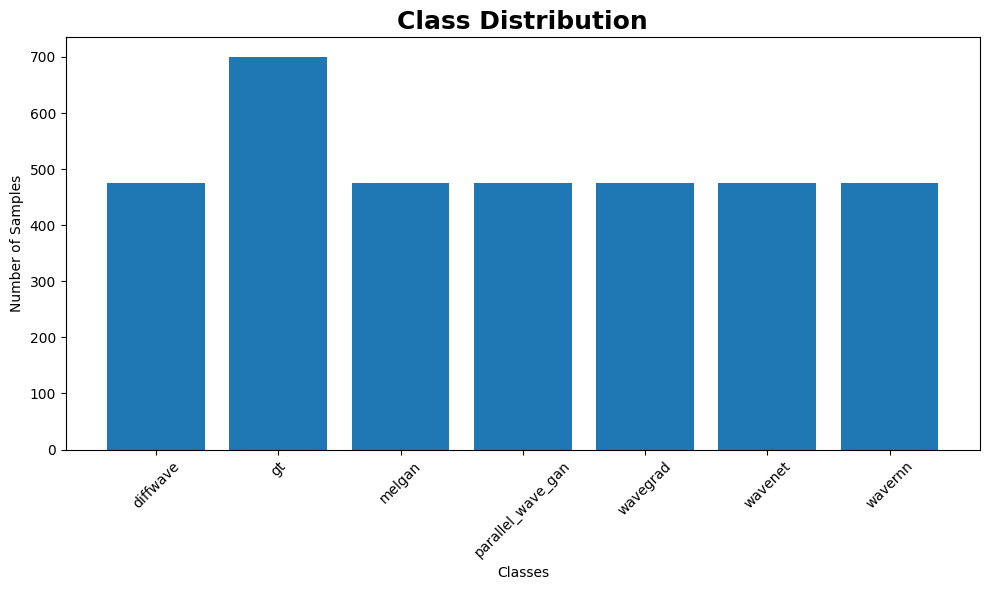

 
---------------------------- Sample Count Diagramming Complete ---------------------------- 


=============================== Calculating Mean and Standard Deviation Statistics ===============================

Raw Data Stats (100 samples):
  Mean: -7.984921
  Std:  71.810768

Scaled Data Stats (100 samples):
  Mean: 0.002547
  Std:  1.012297

Batched Data Stats (5 batches, 80 samples):
  Mean: -0.003208
  Std:  0.997341

---------------------------- Statistics Complete ----------------------------


=============================== Testing Batch Equality ===============================


Batch 1:
  Total samples: 16
  Class distribution:
    Class 0:   1 samples (  6.2%)
    Class 1:   2 samples ( 12.5%)
    Class 3:   3 samples ( 18.8%)
    Class 4:   3 samples ( 18.8%)
    Class 5:   2 samples ( 12.5%)
    Class 6:   5 samples ( 31.2%)


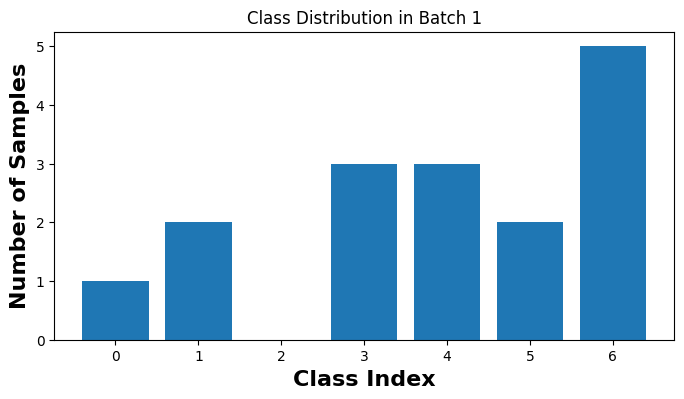


Batch 2:
  Total samples: 16
  Class distribution:
    Class 0:   1 samples (  6.2%)
    Class 1:   3 samples ( 18.8%)
    Class 2:   3 samples ( 18.8%)
    Class 5:   6 samples ( 37.5%)
    Class 6:   3 samples ( 18.8%)


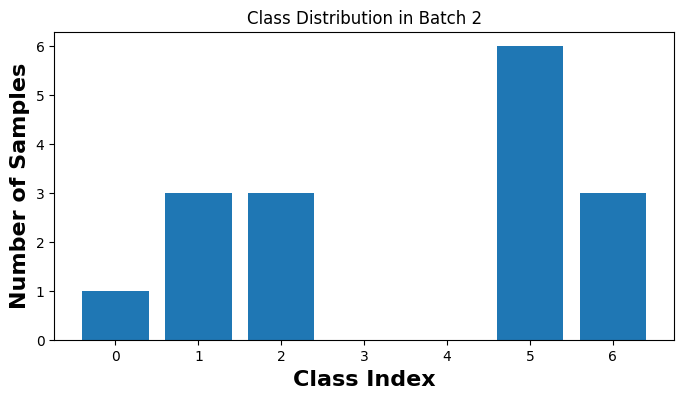


Batch 3:
  Total samples: 16
  Class distribution:
    Class 0:   5 samples ( 31.2%)
    Class 1:   3 samples ( 18.8%)
    Class 2:   3 samples ( 18.8%)
    Class 3:   2 samples ( 12.5%)
    Class 4:   1 samples (  6.2%)
    Class 5:   1 samples (  6.2%)
    Class 6:   1 samples (  6.2%)


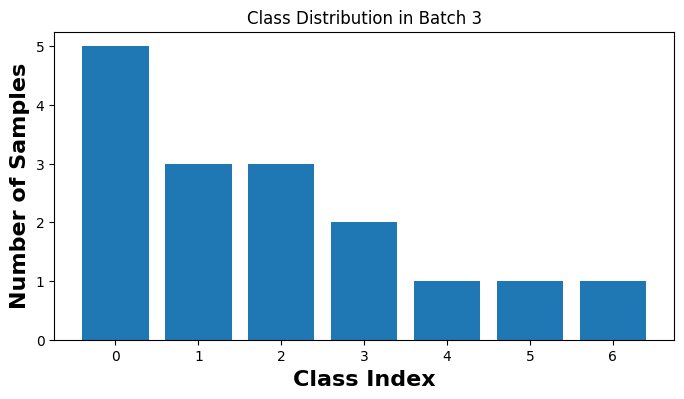


Batch 4:
  Total samples: 16
  Class distribution:
    Class 1:   3 samples ( 18.8%)
    Class 2:   3 samples ( 18.8%)
    Class 3:   3 samples ( 18.8%)
    Class 4:   1 samples (  6.2%)
    Class 5:   3 samples ( 18.8%)
    Class 6:   3 samples ( 18.8%)


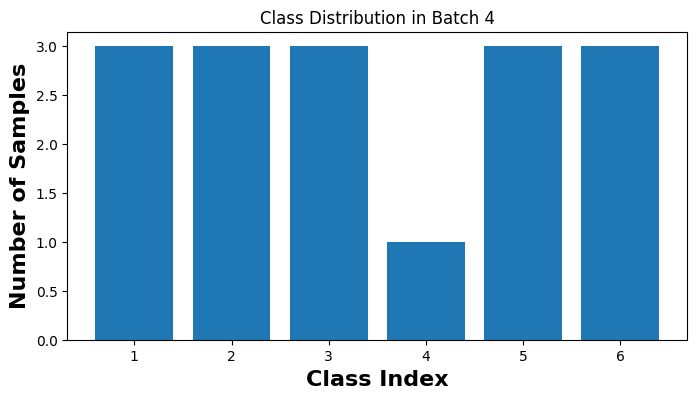


Batch 5:
  Total samples: 16
  Class distribution:
    Class 0:   3 samples ( 18.8%)
    Class 1:   4 samples ( 25.0%)
    Class 2:   1 samples (  6.2%)
    Class 3:   4 samples ( 25.0%)
    Class 4:   1 samples (  6.2%)
    Class 5:   2 samples ( 12.5%)
    Class 6:   1 samples (  6.2%)


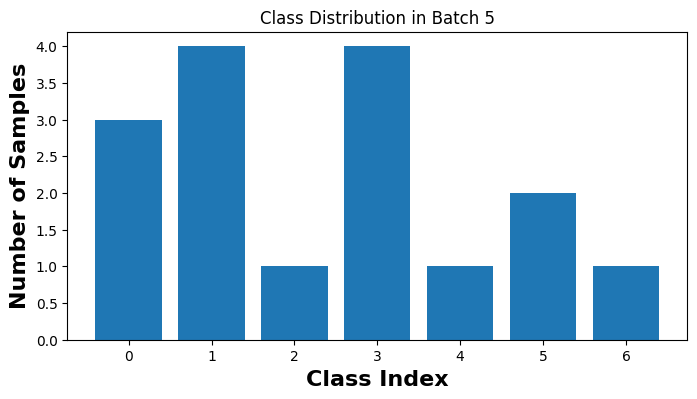


Batch 6:
  Total samples: 16
  Class distribution:
    Class 0:   1 samples (  6.2%)
    Class 1:   4 samples ( 25.0%)
    Class 2:   2 samples ( 12.5%)
    Class 3:   2 samples ( 12.5%)
    Class 4:   1 samples (  6.2%)
    Class 6:   6 samples ( 37.5%)


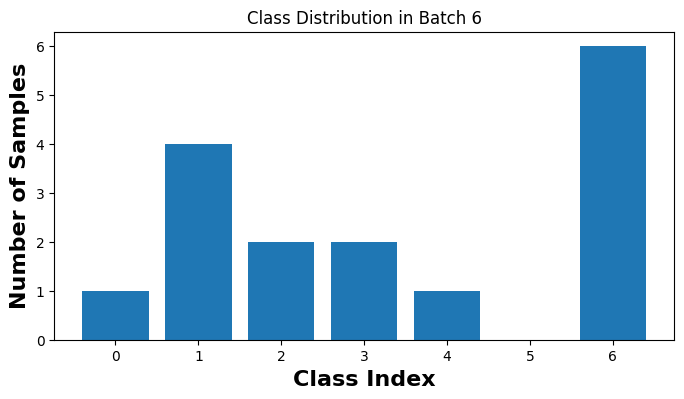


Batch 7:
  Total samples: 16
  Class distribution:
    Class 2:   7 samples ( 43.8%)
    Class 4:   6 samples ( 37.5%)
    Class 5:   1 samples (  6.2%)
    Class 6:   2 samples ( 12.5%)


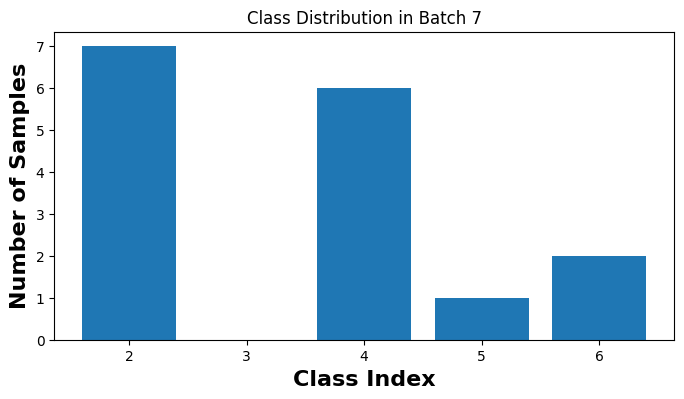


Batch 8:
  Total samples: 16
  Class distribution:
    Class 0:   2 samples ( 12.5%)
    Class 1:   4 samples ( 25.0%)
    Class 2:   2 samples ( 12.5%)
    Class 3:   2 samples ( 12.5%)
    Class 4:   3 samples ( 18.8%)
    Class 6:   3 samples ( 18.8%)


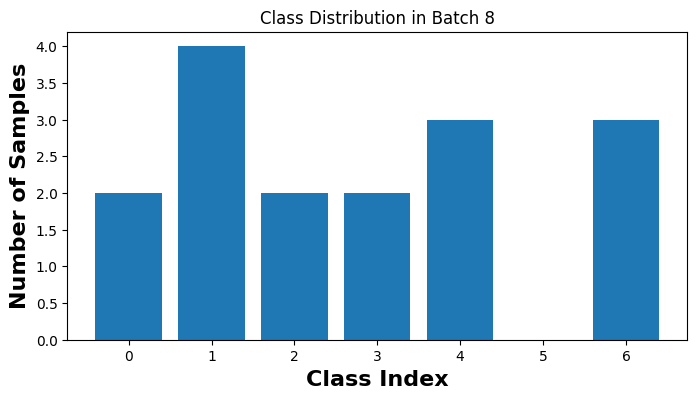


---------------------------- Batch Equality Test Complete ----------------------------


=============================== Plotting Random MFCC Samples ===============================


Plotting 2 MFCC samples from class 'diffwave'...


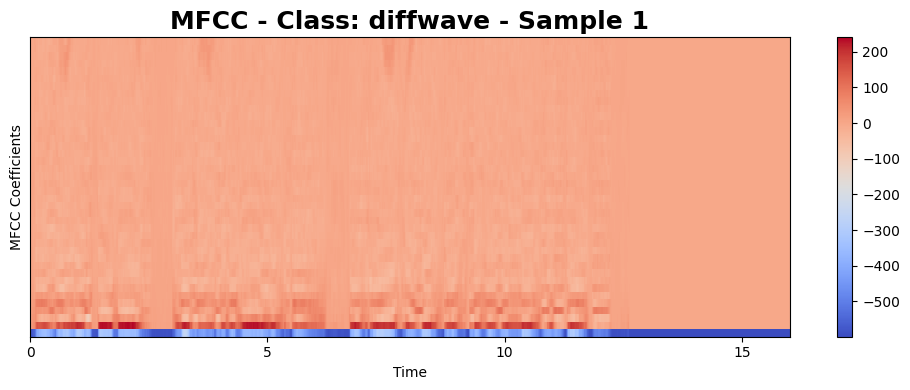

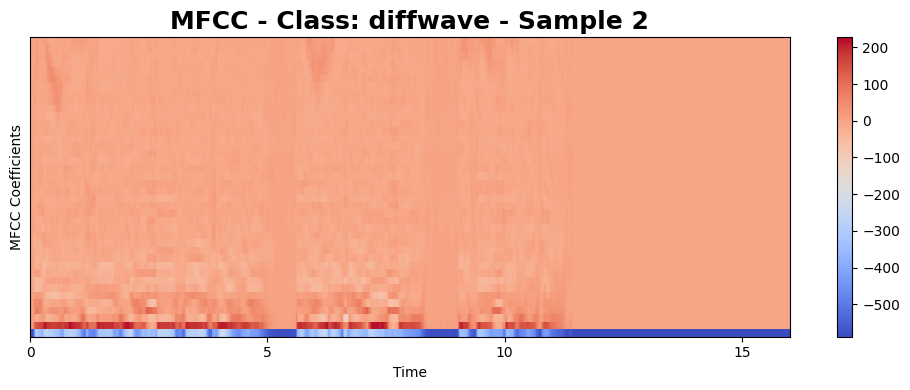


Plotting 2 MFCC samples from class 'gt'...


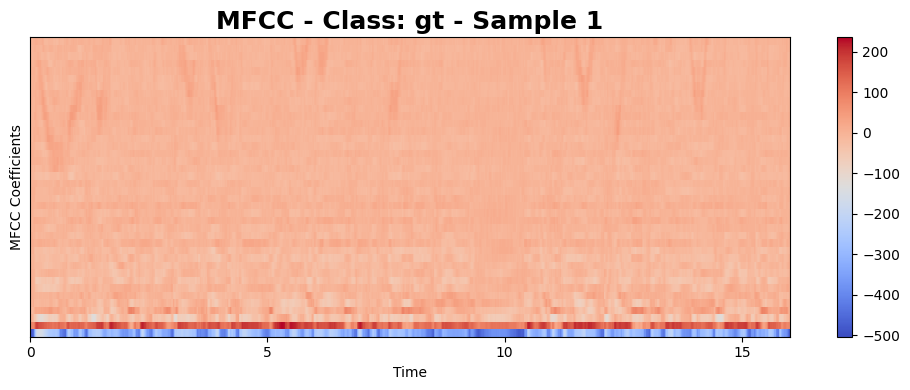

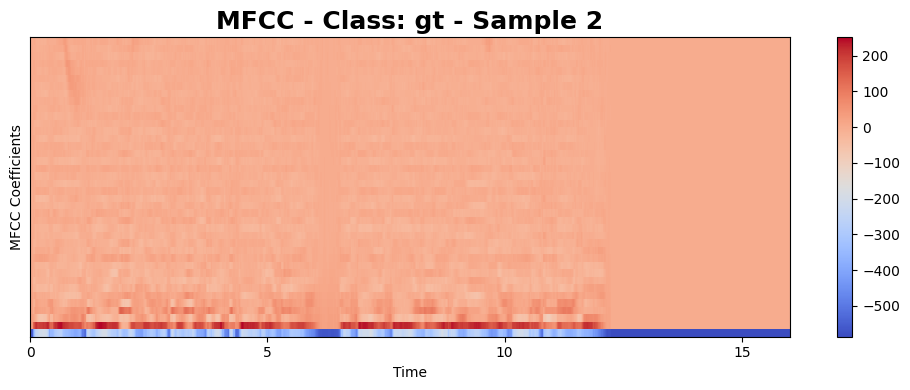


Plotting 2 MFCC samples from class 'melgan'...


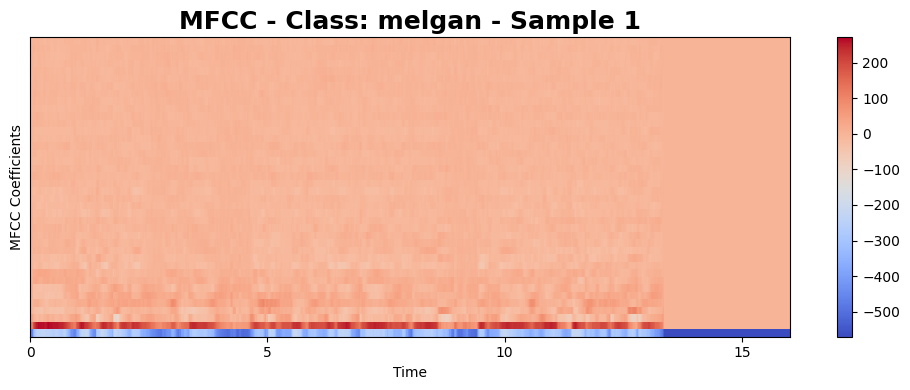

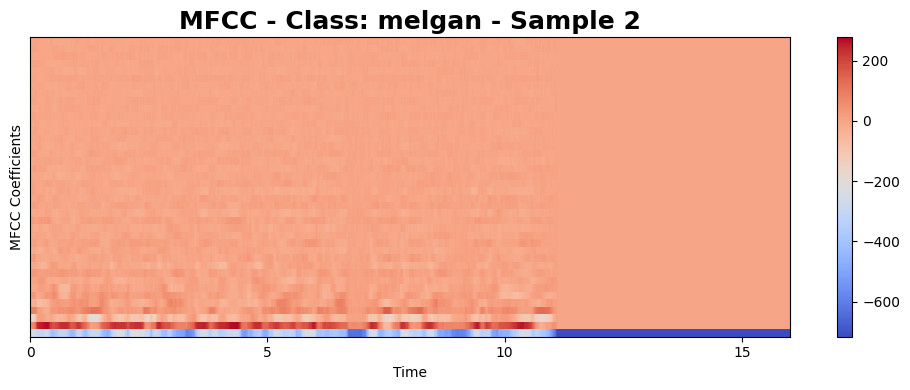


Plotting 2 MFCC samples from class 'parallel_wave_gan'...


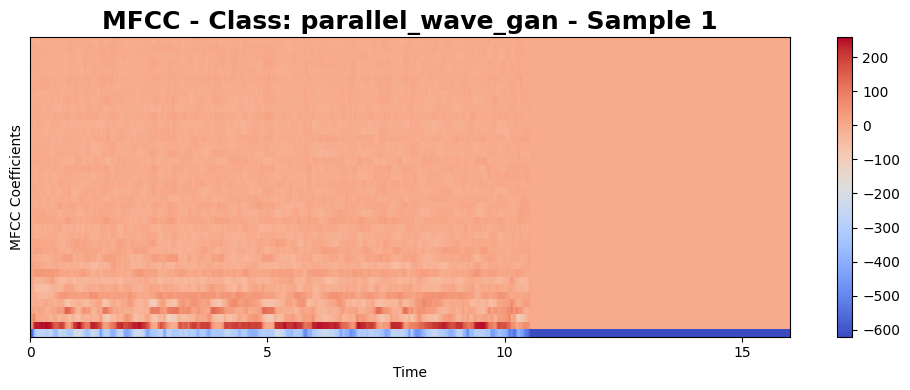

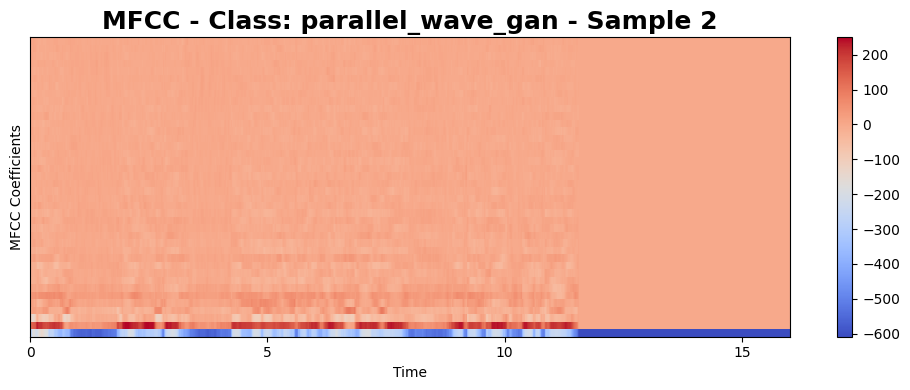


Plotting 2 MFCC samples from class 'wavegrad'...


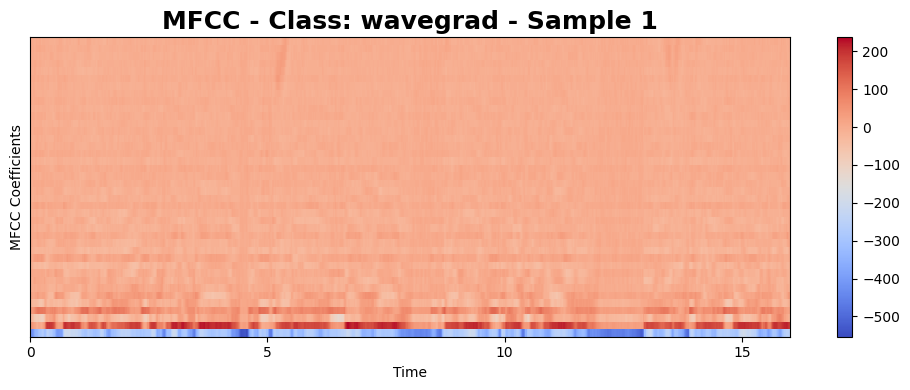

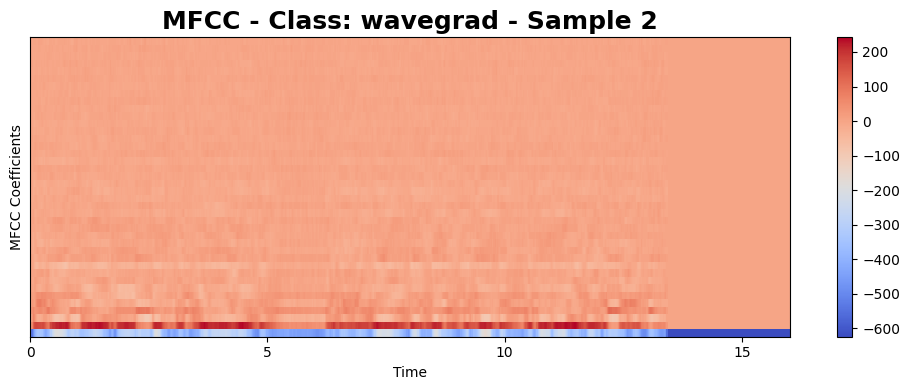


Plotting 2 MFCC samples from class 'wavenet'...


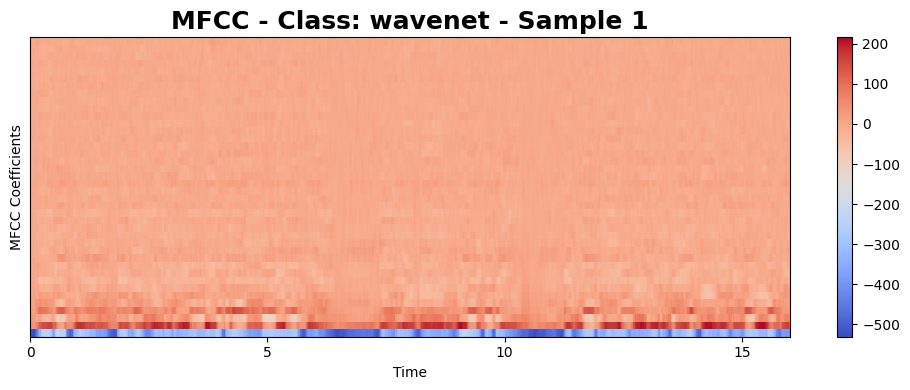

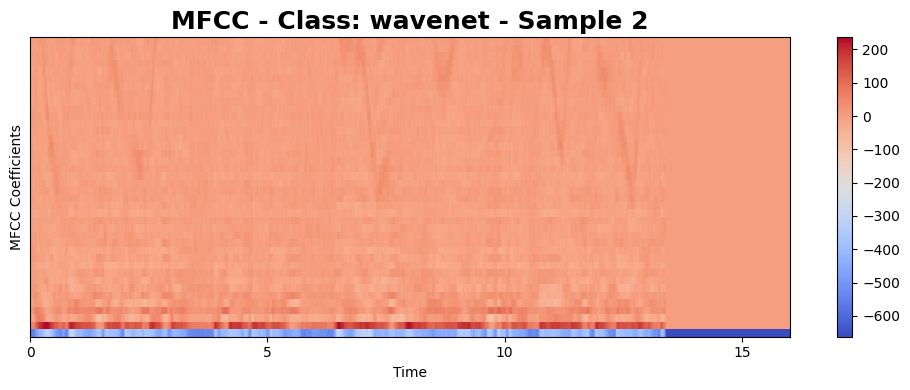


Plotting 2 MFCC samples from class 'wavernn'...


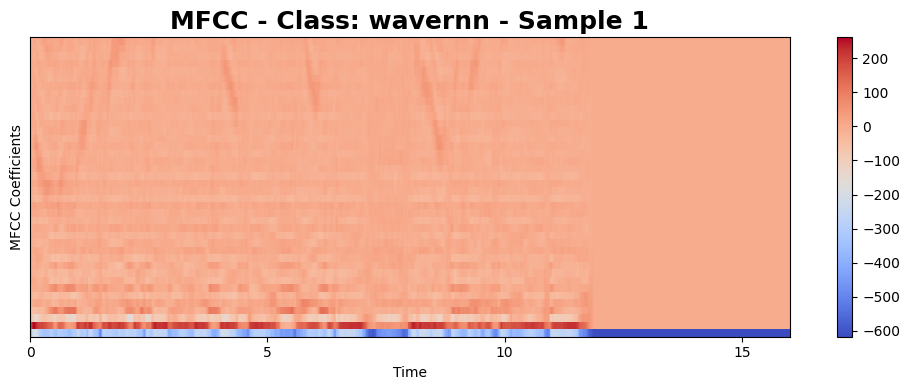

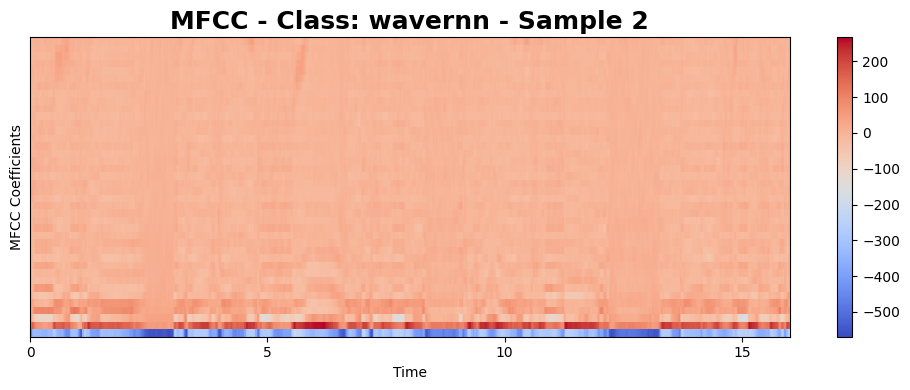


---------------------------- MFCC Plotting Complete ----------------------------


=============================== Optimizer, Loss Function, and Model Architecture ===============================

Loading model from: /content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth
Model loaded successfully.

Chosen Optimizer: <class 'torch.optim.adam.Adam'>
Chosen Loss Function: CrossEntropyLoss()

Model Architecture: DeepFakeDetectorGraphsAndStats(
  (_BatchLossAndOptimization__loss): CrossEntropyLoss()
  (lstm_1): LSTM(40, 256, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm_2): LSTM(512, 1024, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2048, out_features=7, bias=True)
)

---------------------------- Optimizer, Loss Function, and Architecture Complete ----------------------------


=============================== Evaluating Model

[Testing]:   0%|          | 0/34 [00:00<?, ?it/s]


Test Results:
  Average Loss: 0.4280
  Overall Accuracy: 95.31% (508/533)

Per-Class Accuracy:
  diffwave: 92.96% (66/71)
  gt: 94.29% (99/105)
  melgan: 97.18% (69/71)
  parallel_wave_gan: 95.83% (69/72)
  wavegrad: 98.59% (70/71)
  wavenet: 90.28% (65/72)
  wavernn: 98.59% (70/71)

---------------------------- Model Evaluation Complete ----------------------------


=============================== Creating t-SNE Scatter Plot ===============================

Loading model from: /content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth
Model loaded successfully.



Generating Features for t-SNE Plot:   0%|          | 0/34 [00:00<?, ?batch/s]

Feature shape: (533, 2048)
Applying t-SNE to reduce 2048 dimensions to 2D...


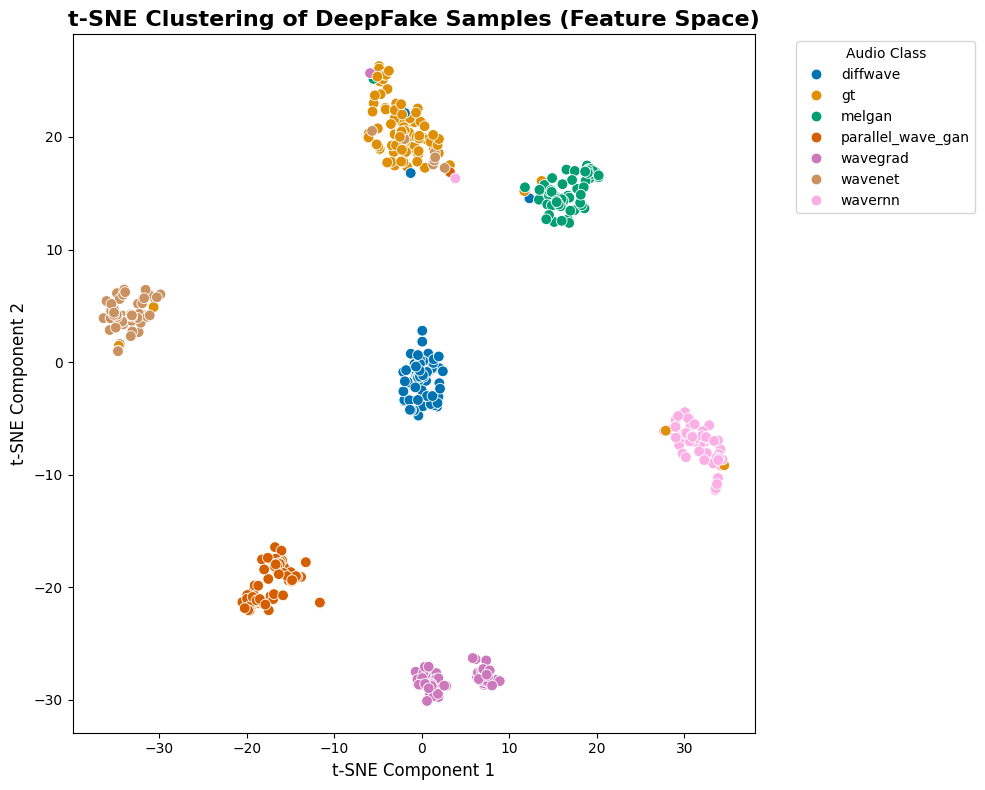


---------------------------- t-SNE Scatter Plot Creation Complete ----------------------------


=============================== Creating Confusion Matrix ===============================

Loading model from: /content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth
Model loaded successfully.


=============================== Setting Up Data Loaders ===============================

Total dataset size: 3550 samples
Split ratios - Train: 0.7, Valid: 0.15, Test: 0.15

Class 'diffwave' (index 0) has 475 samples.
Class 'gt' (index 1) has 700 samples.
Class 'melgan' (index 2) has 475 samples.
Class 'parallel_wave_gan' (index 3) has 475 samples.
Class 'wavegrad' (index 4) has 475 samples.
Class 'wavenet' (index 5) has 475 samples.
Class 'wavernn' (index 6) has 475 samples.

Split sizes - Train: 2485, Valid: 532, Test: 533
Training labels distribution: [333 490 333 332 332 332 333]
Validation labels distribution: [ 71 105  71  71  72  71  

Generating Confusion Matrix:   0%|          | 0/34 [00:00<?, ?batch/s]

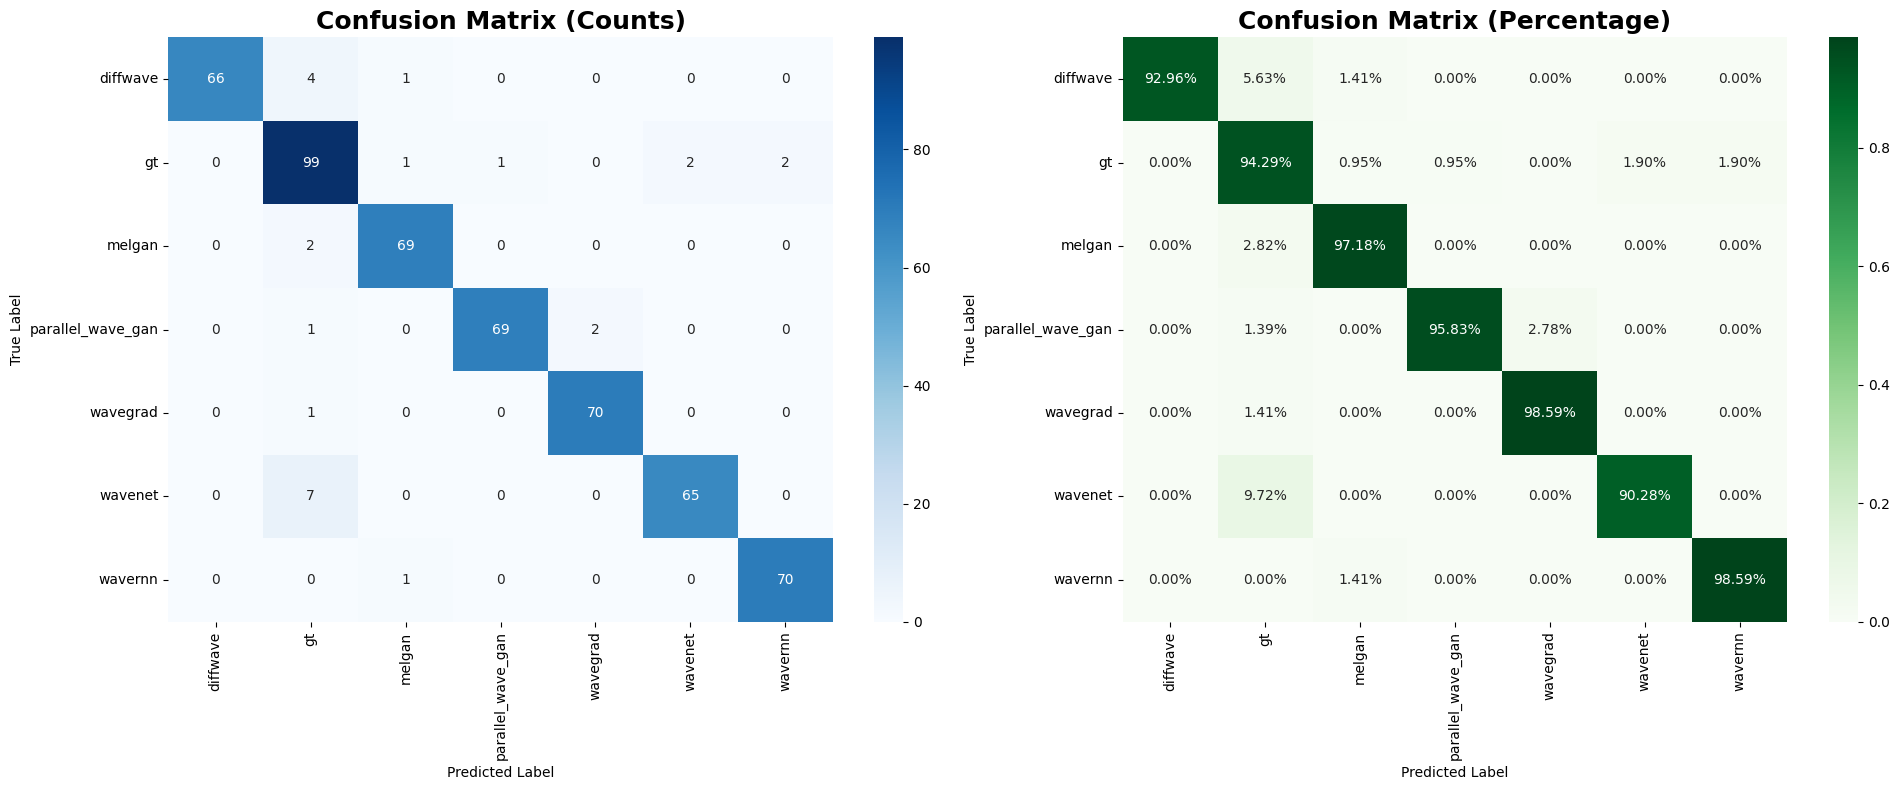


---------------------------- Confusion Matrix Creation Complete ----------------------------


=============================== Creating Classification Report ===============================

Loading model from: /content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth
Model loaded successfully.

Classification Report:

                   precision    recall  f1-score   support

         diffwave       1.00      0.93      0.96        71
               gt       0.87      0.94      0.90       105
           melgan       0.96      0.97      0.97        71
parallel_wave_gan       0.99      0.96      0.97        72
         wavegrad       0.97      0.99      0.98        71
          wavenet       0.97      0.90      0.94        72
          wavernn       0.97      0.99      0.98        71

         accuracy                           0.95       533
        macro avg       0.96      0.95      0.96       533
     weighted avg       0.96   

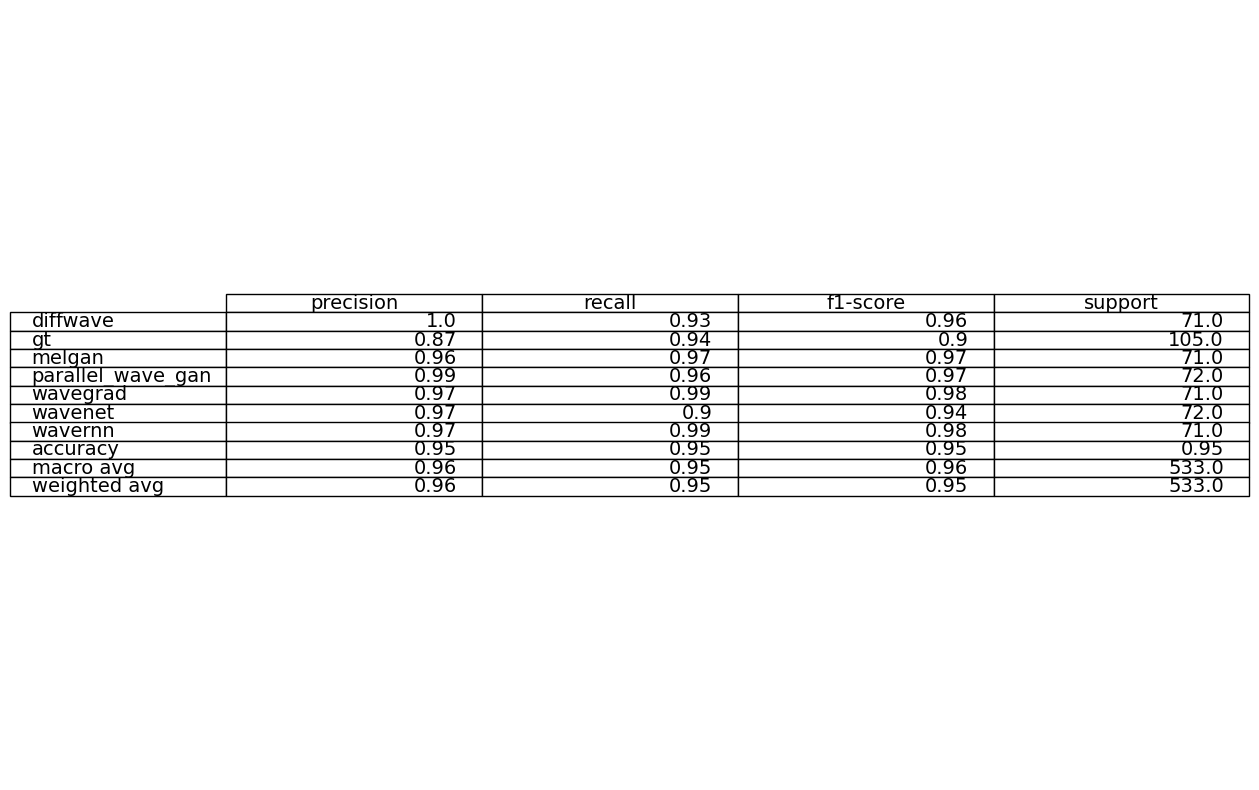


---------------------------- Classification Report Creation Complete ----------------------------


=============================== Plotting ROC Curve with EER ===============================

Loading model from: /content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth
Model loaded successfully.


=============================== Setting Up Data Loaders ===============================

Total dataset size: 3550 samples
Split ratios - Train: 0.7, Valid: 0.15, Test: 0.15

Class 'diffwave' (index 0) has 475 samples.
Class 'gt' (index 1) has 700 samples.
Class 'melgan' (index 2) has 475 samples.
Class 'parallel_wave_gan' (index 3) has 475 samples.
Class 'wavegrad' (index 4) has 475 samples.
Class 'wavenet' (index 5) has 475 samples.
Class 'wavernn' (index 6) has 475 samples.

Split sizes - Train: 2485, Valid: 532, Test: 533
Training labels distribution: [333 490 333 332 332 332 333]
Validation labels distribution: [ 71 105  71  71  72 

Generating ROC Predictions:   0%|          | 0/34 [00:00<?, ?batch/s]

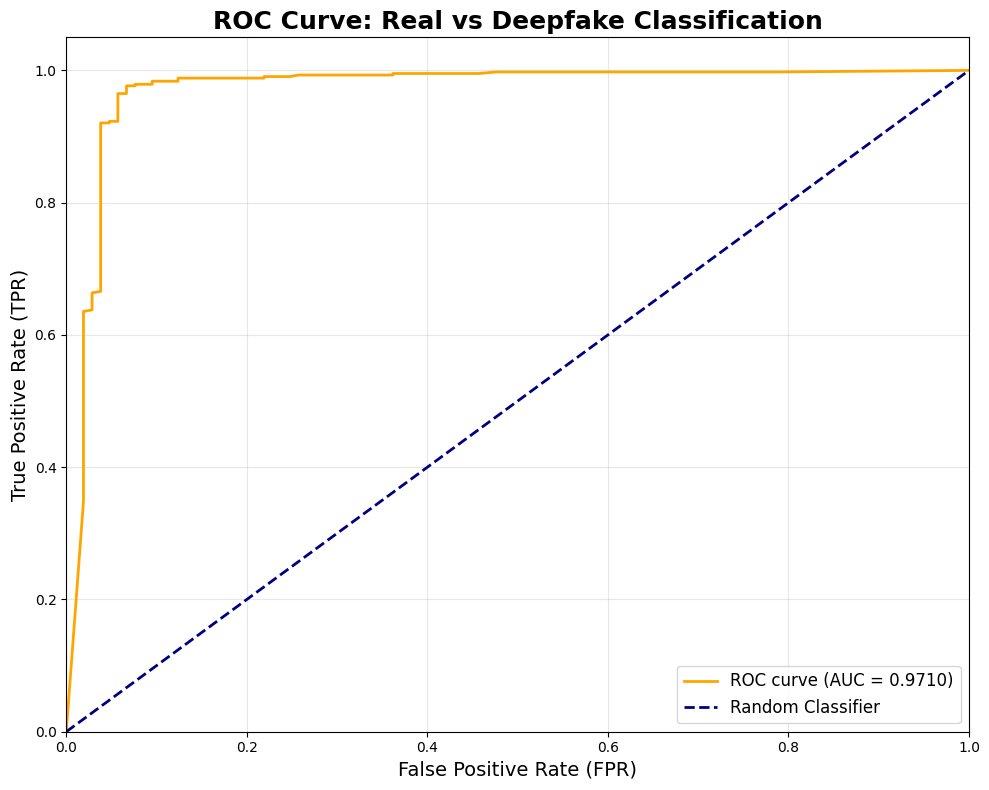

ROC Curve Statistics:
--------------------------------------------
  Area Under Curve (AUC): 0.9710
  Equal Error Rate (EER): 0.0571 (5.71%)
  EER Threshold: 0.9997
--------------------------------------------

---------------------------- ROC Curve with EER Complete ----------------------------



In [7]:
class DeepFakeDetectorGraphsAndStats(PyTorchDeepFakeDetectorLSTM):
    """
    A class to generate graphs and statistics for the DeepFake Detector.
    Inherits from BatchLossAndOptimization, nn.Module, Dataset, and ClassesFilesDictionarySetUp.
    """

    def __init__(self, directory: str = '', file_extension: str = '.wav', loss: str = 'CrossEntropyLoss', optim: str = 'Adam', DL_type: str = 'RNN') -> None:
        """
        Initialize the DeepFakeDetectorGraphsAndStats class.
        Also send directory, file_extension, loss, optim, and DL_type to the parent class.

        Parameters:
            directory (str): Directory containing the dataset.
            file_extension (str): File extension of the audio files.
            loss (str): Loss function to use.
            optim (str): Optimizer to use.
            DL_type (str): Type of deep learning model to use.

        Returns:
            None
        """

        # Initialize the parent class and send parameters up the chain
        super(DeepFakeDetectorGraphsAndStats, self).__init__(directory, file_extension, loss, optim, DL_type)

        # Initialize attributes for storing testing data and predictions
        self.all_labels: List[int] = []
        self.all_predictions: List[int] = []
        self.all_probabilities: np.ndarray = np.array([])


    def plot_training_curves(self) -> None:
        """
        Plot training and validation loss and accuracy curves in 4 subplots.

        Parameters:
            None

        Returns:
            None
        """

        print("\n=============================== Plotting Training Curves ===============================\n")

        # Check if training metrics exist
        if not hasattr(self, 'train_loss_list') or not self.train_loss_list:
            print("No training metrics found. Please train the model first.")
            return

        epochs: range = range(1, len(self.train_loss_list) + 1)

        # Create figure with 4 subplots (2x2 grid)
        plt.figure(figsize=(14, 10))

        # Subplot 1: Training Loss
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.train_loss_list, label='Training Loss', color='blue')
        plt.title('Training Loss', fontsize=18, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.legend()
        plt.grid(True)

        # Subplot 2: Validation Loss
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.val_loss_list, label='Validation Loss', color='orange')
        plt.title('Validation Loss', fontsize=18, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.legend()
        plt.grid(True)

        # Subplot 3: Training Accuracy
        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.train_acc_list, label='Training Accuracy', color='green')
        plt.title('Training Accuracy', fontsize=18, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.legend()
        plt.grid(True)

        # Subplot 4: Validation Accuracy
        plt.subplot(2, 2, 4)
        plt.plot(epochs, self.val_acc_list, label='Validation Accuracy', color='red')
        plt.title('Validation Accuracy', fontsize=18, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.legend()
        plt.grid(True)

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

        print("\n---------------------------- Training Curves Plotted ----------------------------\n")

    def plot_class_counts(self) -> None:
        """
        Plot the distribution of samples per class in the dataset.

        Parameters:
            None

        Returns:
            None
        """

        print(" \n=============================== Sample Count Diagramming =============================== \n")

        # Get class counts
        class_counts: Dict[str, int] = self.get_class_counts()

        # Plotting the class distribution
        plt.figure(figsize=(10, 6))
        # Make sure the classes are the x-axis labels, and the values are the heights of the bars in the y-axis
        plt.bar(list(class_counts.keys()), list(class_counts.values()))
        plt.xlabel("Classes")
        plt.ylabel("Number of Samples")
        plt.title("Class Distribution", fontsize=18, fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(" \n---------------------------- Sample Count Diagramming Complete ---------------------------- \n")


    def test_batch_equality(self, num_batches_to_test: int) -> None:
        """
        Test function to verify that a subset of batches from the training DataLoader are balanced by showing class distributions.

        Parameters:
            num_batches_to_test (int): The number of batches to test for balance.

        Returns:
            None
        """

        print("\n=============================== Testing Batch Equality ===============================\n")

        # Get the training DataLoader
        training_loader: DataLoader = self.get_training_loader()

        # Ensure the training loader is available
        if training_loader is None:
            raise ValueError("Training loader is not set up.")

        # Iterate through the specified number of batches
        for batch_idx, (_, labels) in enumerate(training_loader):

            # Limit to the specified number of batches
            if batch_idx >= num_batches_to_test:
                break

            # Count class distribution in this batch
            label_counts: Counter = Counter(labels.tolist())

            print(f"\nBatch {batch_idx + 1}:")
            print(f"  Total samples: {len(labels)}")
            print(f"  Class distribution:")

            # Print counts and percentages for each class
            for class_idx in sorted(label_counts.keys()):

                # Get count and percentage for this class
                count: int = label_counts[class_idx]
                percentage: float = (count / len(labels)) * 100
                print(f"    Class {class_idx}: {count:3d} samples ({percentage:5.1f}%)")

            # Create a bar plot for this batch's class distribution
            plt.figure(figsize=(8, 4))

            # Only plot if class indices are integers
            if len(label_counts) > 0 and isinstance(next(iter(label_counts.keys())), int):
                # Make sure the class indices are the x-axis labels, and the values are the heights of the bars in the y-axis
                plt.bar(list(label_counts.keys()), list(label_counts.values()))

            plt.xlabel("Class Index", fontsize=16, fontweight='bold')
            plt.ylabel("Number of Samples", fontsize=16, fontweight='bold')
            plt.title(f"Class Distribution in Batch {batch_idx + 1}")
            plt.show()

        print("\n---------------------------- Batch Equality Test Complete ----------------------------\n")


    def plot_random_mfcc_samples(self, samples: int = 3) -> None:
        """
        Plot random MFCC samples from each class using raw audio files.

        Parameters:
            samples (int): Number of random samples to plot for each class. Defaults to 3.

        Returns:
            None
        """

        print("\n=============================== Plotting Random MFCC Samples ===============================\n")

        # Get the file dictionary
        file_dict: dict[int, list[str]] = self.get_file_dictionary()

        # Iterate through each class
        for class_name in self.get_classes():

            # Get class index and corresponding files
            class_index: int = self.get_classes_index()[class_name]
            class_files: list[str] = file_dict[class_index]

            # Randomly sample files from this class
            num_samples: int = min(samples, len(class_files))
            random_indices: np.ndarray = np.random.choice(len(class_files), size=num_samples, replace=False)

            print(f"\nPlotting {num_samples} MFCC samples from class '{class_name}'...")

            # For each randomly selected file
            for i, file_idx in enumerate(random_indices):

                # Get the file path
                file_path: str = class_files[file_idx]

                try:
                    # Load audio file
                    signal, sr = librosa.load(file_path, sr=self.get_sample_rate(), duration=self.get_duration())

                except Exception as e:
                    print(f"\nWarning: Failed to load audio file: {file_path}")
                    print(f"Error: {e}")
                    print("Returning zeros as fallback.\n")

                    # Return zeros with expected shape as fallback
                    signal: np.ndarray = np.zeros(self.get_sample_rate() * self.get_duration())

                    sr: int | float = self.get_sample_rate()

                # Ensure fixed length
                target_length: int = self.get_sample_rate() * self.get_duration()

                # If wave is shorter than target length, pad it; if longer, truncate it
                if len(signal) < target_length:
                    signal = np.pad(signal, (0, target_length - len(signal)), 'constant')
                else:
                    signal = signal[:target_length]

                # Compute MFCCs
                mfccs: np.ndarray = librosa.feature.mfcc(
                    y=signal,
                    sr=sr,
                    n_mfcc=self.get_n_mfcc(),
                    n_fft=self.get_n_fft(),
                    hop_length=self.get_hop_length()
                )

                # Plot MFCCs
                fig, ax = plt.subplots(figsize=(10, 4))
                img = librosa.display.specshow(
                    mfccs,
                    x_axis='time',
                    ax=ax
                )

                # Add color bar
                fig.colorbar(img, ax=ax)
                ax.set(title=f'MFCC - Class: {class_name} - Sample {i+1}', ylabel='MFCC Coefficients')
                ax.title.set_fontsize(18)
                ax.title.set_fontweight('bold')
                plt.tight_layout()
                plt.show()

        print("\n---------------------------- MFCC Plotting Complete ----------------------------\n")

    def mean_and_std_stats(self) -> None:
        """
        Calculate and print the mean and standard deviation of not just the raw data,
        but also the scaled data if scaling is applied.
        Finally, we print out the mean and std for a set of 5 batches from the training DataLoader.

        Parameters:
            None

        Returns:
            None
        """

        print("\n=============================== Calculating Mean and Standard Deviation Statistics ===============================\n")

        # Collect raw data (before scaling and batching) from 100 random samples
        raw_data: List[np.ndarray] = []
        scaled_data: List[np.ndarray] = []
        num_samples: int = min(100, len(self))
        sample_indices: np.ndarray = np.random.choice(len(self), size=num_samples, replace=False)

        # Temporarily disable scaling to get raw data
        use_scaler_original: bool = self.get_use_scaler()
        self.set_use_scaler(False)

        # For each randomly selected sample
        for idx in sample_indices:
            # Get data without scaling
            data, _ = self.__getitem__(idx)

            # If data is a tensor, convert to numpy and flatten
            if isinstance(data, torch.Tensor):
                raw_data.append(data.numpy().flatten())

        # Re-enable scaling to get scaled data
        self.set_use_scaler(use_scaler_original)

        # For each randomly selected sample, if scaling is enabled
        if use_scaler_original and self.get_scaler() is not None:
            for idx in sample_indices:

                # Get data with scaling
                data, _ = self.__getitem__(idx)

                # If data is a tensor, convert to numpy and flatten
                if isinstance(data, torch.Tensor):
                    scaled_data.append(data.numpy().flatten())

        # Print raw data stats
        if raw_data:
            raw_concat: np.ndarray = np.concatenate(raw_data)
            print(f"Raw Data Stats ({len(raw_data)} samples):")
            print(f"  Mean: {np.mean(raw_concat):.6f}")
            print(f"  Std:  {np.std(raw_concat):.6f}\n")

        # Print scaled data stats
        if scaled_data:
            scaled_concat: np.ndarray = np.concatenate(scaled_data)
            print(f"Scaled Data Stats ({len(scaled_data)} samples):")
            print(f"  Mean: {np.mean(scaled_concat):.6f}")
            print(f"  Std:  {np.std(scaled_concat):.6f}\n")

        # Collect data from first 5 batches
        training_loader: DataLoader = self.get_training_loader()

        # Ensure the training loader is available
        if training_loader is not None:
            batch_data = []

            # Iterate through first 5 batches
            for batch_idx, (data, _) in enumerate(training_loader):

                # If we've collected 5 batches, stop
                if batch_idx >= 5:
                    break

                # If data is a tensor, convert to numpy
                if isinstance(data, torch.Tensor):
                    batch_data.append(data.numpy())

            # If we have batch data, compute and print stats
            if batch_data is not None and len(batch_data) > 0:
                # Concatenate all batch data
                all_data: np.ndarray = np.concatenate([b.reshape(b.shape[0], -1) for b in batch_data], axis=0)

                # Show the length and shape of the data
                print(f"Batched Data Stats ({len(batch_data)} batches, {all_data.shape[0]} samples):")

                # Print mean and std
                print(f"  Mean: {np.mean(all_data):.6f}")
                print(f"  Std:  {np.std(all_data):.6f}")

        print("\n---------------------------- Statistics Complete ----------------------------\n")

    def print_optimizer_loss_architecture(self, past_model: str = 'None') -> None:
        """
        Print the chosen optimizer, loss function, and model architecture.

        Parameters:
            past_model (str): Path to a saved model to load before evaluation. Defaults to 'None'.

        Returns:
            None
        """

        print("\n=============================== Optimizer, Loss Function, and Model Architecture ===============================\n")

        # Load past model if provided
        if past_model != 'None':
            print(f"Loading model from: {past_model}")
            self.load_state_dict(torch.load(past_model, map_location=self.get_device()), strict=False)
            print("Model loaded successfully.\n")

        # If we don't have optimizer or loss set, set them to defaults
        if self.get_optim() is None or not isinstance(self.get_optim(), torch.optim.Optimizer) or self.get_loss() is None or not isinstance(self.get_loss(), nn.Module):
            optimizer: type[torch.optim.Optimizer] = self.set_optim('Adam')
            loss_function: nn.Module = self.set_loss('CrossEntropyLoss')

        # Otherwise, get the current optimizer and loss
        else:
            optimizer: type[torch.optim.Optimizer] = self.get_optim()
            loss_function: nn.Module = self.get_loss()


        print(f"Chosen Optimizer: {optimizer}")
        print(f"Chosen Loss Function: {loss_function}\n")

        # Print model architecture
        print(f"Model Architecture: {self}")


        print("\n---------------------------- Optimizer, Loss Function, and Architecture Complete ----------------------------\n")


    def create_confusion_matrix(self, past_model: str = 'None') -> None:
        """
        Create and display a confusion matrix for the model's predictions on the test set.

        Parameters:
            past_model (str): Path to a saved model to load before evaluation. Defaults to 'None'.

        Returns:
            None
        """

        print("\n=============================== Creating Confusion Matrix ===============================\n")

        # Load past model and use it if provided
        if past_model != 'None':
            print(f"Loading model from: {past_model}")
            self.load_state_dict(torch.load(past_model, map_location=self.get_device()), strict=False)
            print("Model loaded successfully.\n")


        # Generate predictions if not already done and if a past model is provided
        if (self.get_testing_loader() is None or len(self.all_labels) == 0 or len(self.all_predictions) == 0) and past_model != 'None':
            self.setup_data_loaders()

            # Ensure the testing loader is available
            if self.get_testing_loader() is None:
                raise ValueError("Testing DataLoader is not available. Please call setup_data_loaders() first.")

            self.eval()  # Set model to evaluation mode

            self.all_labels: list[int] = []
            self.all_predictions: list[int] = []

            # Generate predictions
            with torch.no_grad() :

                # Iterate through the testing data
                for data, labels in tqdm(self.get_testing_loader(), desc="Generating Confusion Matrix", unit="batch"):

                    # Move data to the appropriate device
                    data: torch.Tensor = data.to(self.get_device())
                    labels: torch.Tensor = labels.to(self.get_device())

                    # Get model outputs
                    outputs: torch.Tensor = self(data)

                    # Get predicted classes
                    _, predicted = torch.max(outputs, dim=1)

                    # Store true labels and predictions
                    self.all_labels.extend(labels.cpu().numpy())
                    self.all_predictions.extend(predicted.cpu().numpy())

        # Compute confusion matrix
        cm: np.ndarray = confusion_matrix(self.all_labels, self.all_predictions)

        # Create figure with two subplots side by side
        _, (ax_counts, ax_percentage) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot raw counts confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.get_classes(), yticklabels=self.get_classes(), ax=ax_counts)
        ax_counts.set_xlabel('Predicted Label')
        ax_counts.set_ylabel('True Label')
        ax_counts.set_title('Confusion Matrix (Counts)', fontsize=18, fontweight='bold')

        # Create percentage-based confusion matrix
        cm_percentage: np.ndarray = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot percentage-based confusion matrix
        sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Greens',
                    xticklabels=self.get_classes(), yticklabels=self.get_classes(), ax=ax_percentage)
        ax_percentage.set_xlabel('Predicted Label')
        ax_percentage.set_ylabel('True Label')
        ax_percentage.set_title('Confusion Matrix (Percentage)', fontsize=18, fontweight='bold')


        plt.tight_layout()
        plt.subplots_adjust(left=0.1) # Add extra margin on the left to prevent labels from being cut off
        plt.show()

        print ("\n---------------------------- Confusion Matrix Creation Complete ----------------------------\n")


    def create_classification_report(self, past_model: str = 'None') -> None:
        """
        Create and display a classification report for the model's predictions on the test set.

        Parameters:
            past_model (str): Path to a saved model to load before evaluation. Defaults to 'None'.

        Returns:
            None
        """

        print("\n=============================== Creating Classification Report ===============================\n")

        # Load past model if provided
        if past_model != 'None':
            print(f"Loading model from: {past_model}")
            self.load_state_dict(torch.load(past_model, map_location=self.get_device()), strict=False)
            print("Model loaded successfully.\n")

        # Check if predictions are already generated and generate them if not
        if (self.get_testing_loader() is None or len(self.all_labels) == 0 or len(self.all_predictions) == 0) and past_model != 'None':

            # Generate predictions if not already done
            self.setup_data_loaders()

            # Ensure the testing loader is available
            if self.get_testing_loader() is None:
                raise ValueError("Testing DataLoader is not available. Please call setup_data_loaders() first.")

            self.eval()  # Set model to evaluation mode

            # Set up lists to store true labels and predictions
            self.all_labels: list[int] = []
            self.all_predictions: list[int] = []

            # Generate predictions
            with torch.no_grad():

                # For each batch in the testing loader
                for data, labels in tqdm(self.get_testing_loader(), desc="Generating Classification Report", unit="batch"):

                    # Move data to the appropriate device
                    data: torch.Tensor = data.to(self.get_device())
                    labels: torch.Tensor = labels.to(self.get_device())

                    # Get model outputs and predicted classes
                    outputs: torch.Tensor = self(data)
                    _, predicted = torch.max(outputs, dim=1)

                    # Store true labels and predictions
                    self.all_labels.extend(labels.cpu().numpy())
                    self.all_predictions.extend(predicted.cpu().numpy())

        # Generate classification report
        report: str | Dict[str, float] = classification_report(self.all_labels, self.all_predictions, target_names=self.get_classes())
        print("Classification Report:\n")
        print(report)

        # Make classification report into matplotlib table
        report_dict: str | Dict[str, float] = classification_report(self.all_labels, self.all_predictions, target_names=self.get_classes(), output_dict=True)
        report_df: pd.DataFrame = pd.DataFrame(report_dict).transpose()
        plt.figure(figsize=(12, 10))
        plt.axis('off')
        # Create table with formatted font sizes and weights
        table = plt.table(cellText=np.round(report_df.values, 2), colLabels=report_df.columns, rowLabels=report_df.index, loc='center')
        table.scale(1.1, 1.1)
        table.auto_set_font_size(False)
        table.set_fontsize(14)

        plt.show()

        print ("\n---------------------------- Classification Report Creation Complete ----------------------------\n")


    def sns_scatter_plot(self, past_model: str = 'None') -> None:
        """
        Create and display a seaborn scatter plot using t-SNE for the model's predictions on the test set.

        Parameters:
            past_model (str): Path to a saved model to load before evaluation. Defaults to 'None'.

        Returns:
            None
        """

        print("\n=============================== Creating t-SNE Scatter Plot ===============================\n")

        # Load past model if provided
        if past_model != 'None':
            print(f"Loading model from: {past_model}")
            self.load_state_dict(torch.load(past_model, map_location=self.get_device()), strict=False)
            print("Model loaded successfully.\n")

        # Check if testing loader is available
        if self.get_testing_loader() is None:
            self.setup_data_loaders()

            # If not, raise error
            if self.get_testing_loader() is None:
                self.setup_data_loaders()
                raise ValueError("Testing DataLoader is not available. Please call setup_data_loaders() first.")

        # Start evaluation of model
        self.eval()  # Set model to evaluation mode

        # Set up separate lists to store batches of features and labels
        features_list: list = []
        labels_list: list = []


        # Generate features and calculate accuracy
        with torch.no_grad():
            # Iterates through data
            for samples, labels in tqdm(self.get_testing_loader(), desc="Generating Features for t-SNE Plot", unit="batch"):

                # Move data to the appropriate device
                samples: torch.Tensor = samples.to(self.get_device())
                labels: torch.Tensor = labels.to(self.get_device())

                # Forward pass to calculate accuracy
                outputs: torch.Tensor = self(samples)

                # Extract features using the model's feature extractor
                features: torch.Tensor = self.extract_features(samples)

                # Store features and labels (move to CPU)
                features_list.append(features.cpu().numpy())
                labels_list.append(labels.cpu().numpy())


        # Concatenate all feature outputs and labels
        X_output: np.ndarray = np.concatenate(features_list, axis=0)
        y_output: np.ndarray = np.concatenate(labels_list)

        print(f"Feature shape: {X_output.shape}")
        print(f"Applying t-SNE to reduce {X_output.shape[1]} dimensions to 2D...")

        # Initialize t-SNE
        tsne: TSNE = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')

        # Fit and transform the feature outputs
        X_embedded: np.ndarray = tsne.fit_transform(X_output)

        # Create the plot
        plt.figure(figsize=(10, 8))

        # Use seaborn's colorblind-friendly palette
        scatter = sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_output, palette='colorblind', s=60)

        # Set plot titles and labels
        plt.title("t-SNE Clustering of DeepFake Samples (Feature Space)", fontsize=16, fontweight='bold')
        plt.xlabel("t-SNE Component 1", fontsize=12)
        plt.ylabel("t-SNE Component 2", fontsize=12)

        # Update legend with class names
        handles, _ = scatter.get_legend_handles_labels()
        class_names: list[str] = self.get_classes()
        plt.legend(handles, class_names, title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

        print("\n---------------------------- t-SNE Scatter Plot Creation Complete ----------------------------\n")


    def plot_roc_curve_with_eer(self, past_model: str = 'None') -> None:
        """
        Plot ROC curve for binary classification (gt vs deepfake) and compute Equal Error Rate (EER).
        Combines all 6 deepfake classes into one 'deepfake' category vs ground truth 'real' category.

        Parameters:
            past_model (str): Path to a saved model to load before evaluation. Defaults to 'None'.

        Returns:
            None
        """

        print("\n=============================== Plotting ROC Curve with EER ===============================\n")

        # Load past model if specified
        if past_model != 'None':
            print(f"Loading model from: {past_model}")
            self.load_state_dict(torch.load(past_model, map_location=self.get_device()), strict=False)
            print("Model loaded successfully.\n")

        # Check if predictions are already generated and generate them if not (Note: we need probabilities here so we regenerate if needed)
        if (self.get_testing_loader() is None or len(self.all_labels) == 0 or self.all_probabilities.size == 0) and past_model != 'None':

            # Generate predictions if not already done
            self.setup_data_loaders()

            # Ensure the testing loader is available
            if self.get_testing_loader() is None:
                raise ValueError("Testing DataLoader is not available. Please call setup_data_loaders() first.")

            self.eval()  # Set model to evaluation mode

            # Set up lists to store true labels
            self.all_labels: List[int] = []

            # Store probability scores for ROC curve
            all_probabilities: List[np.ndarray] = []

            # Generate predictions
            with torch.no_grad():

                # For each batch in the testing loader
                for data, labels in tqdm(self.get_testing_loader(), desc="Generating ROC Predictions", unit="batch"):

                    # Move data to the appropriate device
                    data: torch.Tensor = data.to(self.get_device())
                    labels: torch.Tensor = labels.to(self.get_device())

                    # Get model outputs and predicted classes
                    outputs: torch.Tensor = self(data)

                    # Apply softmax to get probabilities
                    probabilities = torch.softmax(outputs, dim=1)

                    # Store true labels, predictions, and probabilities
                    self.all_labels.extend(labels.cpu().numpy())
                    all_probabilities.append(probabilities.cpu().numpy())

            # Concatenate all probabilities
            self.all_probabilities = np.concatenate(all_probabilities, axis=0)

        # Get the index for 'gt' class (ground truth/real)
        gt_class_index: int | None = self.get_classes_index().get('gt')

        # If it doesn't exist, raise error
        if gt_class_index is None:
            raise ValueError("Ground truth class 'gt' not found in classes.")

        # Prepare binary labels and deepfake probabilities
        all_labels_binary: np.ndarray = np.array([])

        # Convert multi-class labels to binary: gt (real) = 0, all others (deepfake) = 1
        for label in self.all_labels:
            if label == gt_class_index:
                all_labels_binary = np.append(all_labels_binary, [0])
            else:
                all_labels_binary = np.append(all_labels_binary, [1])

        # Get deepfake probability scores: P(deepfake) = 1 - P(gt)
        deepfake_probabilities: np.ndarray = 1.0 - self.all_probabilities[:, gt_class_index]

        # Set up variables for ROC computation
        fpr: np.ndarray = np.ndarray([])
        tpr: np.ndarray = np.ndarray([])
        thresholds: np.ndarray = np.ndarray([])

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(all_labels_binary, deepfake_probabilities)
        roc_auc: float = float(auc(fpr, tpr))

        # Compute EER and ERR threshold using the two-line approach (Thanks to Changjiang at https://yangcha.github.io/EER-ROC/)!
        eer: tuple = (brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.))
        eer_threshold: float = float(interp1d(fpr, thresholds)(eer))


        # Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)', fontsize=14)
        plt.ylabel('True Positive Rate (TPR)', fontsize=14)
        plt.title('ROC Curve: Real vs Deepfake Classification', fontsize=18, fontweight='bold')
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print ROC and EER statistics
        print(f"ROC Curve Statistics:")
        print(f"--------------------------------------------")
        print(f"  Area Under Curve (AUC): {roc_auc:.4f}")
        print(f"  Equal Error Rate (EER): {eer:.4f} ({eer*100:.2f}%)")
        print(f"  EER Threshold: {eer_threshold:.4f}")
        print(f"--------------------------------------------")

        print("\n---------------------------- ROC Curve with EER Complete ----------------------------\n")


    def save_model(self, save_path: str = '/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V10.pth') -> None:
        """
        Save the trained model to disk or Google Drive.

        Parameters:
            save_path (str): Path where the model should be saved.

        Returns:
            None
        """

        print(f"\n=============================== Saving Model ===============================\n")

        # Save the model state dictionary
        torch.save(self.state_dict(), save_path)
        print(f"Model saved successfully to: {save_path}")

        print("\n---------------------------- Model Save Complete ----------------------------\n")

# For testing (comment everything below out if you don't want to test right away)
if __name__ == "__main__":
    detector = DeepFakeDetectorGraphsAndStats(directory='/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/LibriSeVoc', file_extension='.wav', loss='CrossEntropyLoss', optim='Adam', DL_type='RNN')
    detector.set_batch_size(16) # Make it 16 samples per batch
    detector.set_learning_rate(0.001) # Set learning rate to 0.001
    detector.setup_data_loaders()
    detector.plot_class_counts()

    detector.mean_and_std_stats()
    detector.test_batch_equality(8)
    detector.plot_random_mfcc_samples(samples=2) # Plot 2 random MFCC samples per class

    detector.print_optimizer_loss_architecture('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth')
    detector.evaluate_model('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth')
    detector.sns_scatter_plot('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth')
    detector.create_confusion_matrix('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth')
    detector.create_classification_report('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth')
    detector.plot_roc_curve_with_eer('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V15.pth')

In [8]:
def main() -> None:
    if os.path.exists('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/LibriSeVoc'):
        detector = DeepFakeDetectorGraphsAndStats(directory='/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/LibriSeVoc', file_extension='.wav', loss='CrossEntropyLoss', optim='Adam', DL_type='RNN')
        detector.set_batch_size(16) # Make it 16 samples per batch
        detector.set_duration(6) # Set duration to 6 seconds
        detector.set_learning_rate(0.0008) # Set learning rate to 0.001
        detector.setup_data_loaders() # Setup data loaders
        detector.set_optim("Adam") # Set optimizer to Adam
        detector.train_LSTM(num_epochs=100) # Train for 100 epochs
        detector.save_model('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V16.pth') # Save the trained model

        detector.plot_training_curves()
        detector.plot_class_counts()
        detector.print_optimizer_loss_architecture('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V16.pth')
        detector.evaluate_model('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V16.pth')
        detector.sns_scatter_plot('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V16.pth')
        detector.create_confusion_matrix('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V16.pth')
        detector.create_classification_report('/content/drive/My Drive/CYBR_4980_Project/Dataset_Extracted/LibriSeVoc_extracted/Deep_Fake_Detector_LSTM_V16.pth')
    else:
        print("Dataset directory does not exist.")

if __name__ == "__main__":
    main()

 =============================== Device Setup =============================== 

Using device: cpu
CUDA not available, using CPU.

 ----------------------------- Setup Complete ------------------------------ 

 
=============================== Creating Classes, Class Counts, and Class Indices =============================== 

 Classes found:  ['diffwave', 'gt', 'melgan', 'parallel_wave_gan', 'wavegrad', 'wavenet', 'wavernn']
 Class counts:  {'diffwave': 13201, 'gt': 13201, 'melgan': 13201, 'parallel_wave_gan': 13201, 'wavegrad': 13201, 'wavenet': 13201, 'wavernn': 13201}
 Class indices:  {'diffwave': 0, 'gt': 1, 'melgan': 2, 'parallel_wave_gan': 3, 'wavegrad': 4, 'wavenet': 5, 'wavernn': 6}
 
----------------------------- Creation of Classes, Class Counts, and Class Indices Complete ------------------------------ 

 
=============================== Setting up File Dictionary =============================== 


 Class diffwave: Files: ['1040_133433_000052_000001_gen.wav', '1088_129236_000

Epoch 1/100 [Training]:   0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: 